In [1]:
import copy
from pathlib import Path
import warnings
import random

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

import matplotlib.pyplot as plt

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [2]:
"""
group = [
    [34, 40, 42, 41, 4, 10, 11, 12],
    [35, 6, 48, 27, 57, 8, 25, 56, 26, 55, 47, 13, 53, 18, 7, 17, 46],
    [31, 33, 9, 3, 1, 32],
    [29, 38, 43, 58, 15, 22, 39, 54, 23, 44, 45, 37, 52, 2, 14],
    [21, 19, 50, 49, 20, 51, 30, 36, 28, 59, 5, 60, 16, 24]
]
"""

# A setting
building_num_A = [4, 10, 11, 12, 34, 40, 41, 42] # 8
checking_tag_A = ['4', "A", "A", '12', '34', '40', '41', '42']
model_paths_A = ["Archive/A/4_B.ckpt", "Archive/A/A.ckpt", "Archive/A/A.ckpt", "Archive/A/12_B.ckpt", "Archive/A/34_B.ckpt",
"Archive/A/40_B.ckpt", "Archive/A/41_B.ckpt", "Archive/A/42_B.ckpt"]

# B setting
building_num_B = [6, 7, 8, 13, 17, 18, 25, 26, 27, 35, 46, 47, 48, 53, 55, 56, 57] # 17
checking_tag_B = ['B' for i in range(17)]
model_paths_B = ['Archive/B/B.ckpt' for i in range(17)]

# C setting
building_num_C = [1, 3, 9, 31, 32, 33] # 6
checking_tag_C = ['C' for i in range(6)]
model_paths_C = ['Archive/C/C.ckpt' for i in range(6)]

# D setting
building_num_D = [2, 14, 15, 22, 23, 29, 37, 38, 39, 43, 44, 45, 52, 54, 58] # 15
checking_tag_D = ['D' for i in range(15)]
model_paths_D = ['Archive/D/D.ckpt' for i in range(15)]

# E setting
building_num_E = [5, 16, 19, 20, 21, 24, 28, 30, 36, 49, 50, 51, 59, 60] # 14
checking_tag_E = ['E' for i in range(14)]
model_paths_E = ['Archive/E/E.ckpt' for i in range(14)]

In [3]:
checking_tag_E[12] = "59"
model_paths_E[12] = "Archive/E/59_B.ckpt"

In [4]:
building_num = building_num_A + building_num_B + building_num_C + building_num_D + building_num_E
checking_tag = checking_tag_A + checking_tag_B + checking_tag_C + checking_tag_D + checking_tag_E
model_paths = model_paths_A + model_paths_B + model_paths_C + model_paths_D + model_paths_E

input_length = 168
output_length = 24

show_graph = True

random_choice = 3 # random.randrange(2,13)

In [5]:
data_paths = []
for i in range(len(building_num)):
    if checking_tag[i].isdigit():
        data_paths.append(f"Refined_Data/Seperated_Data/{checking_tag[i]}.csv")
    else:
        data_paths.append(f"Refined_Data/Grouped_Data/{checking_tag[i]}.csv")

In [6]:
start_point = -168 * random_choice - 1
duration = 168

def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

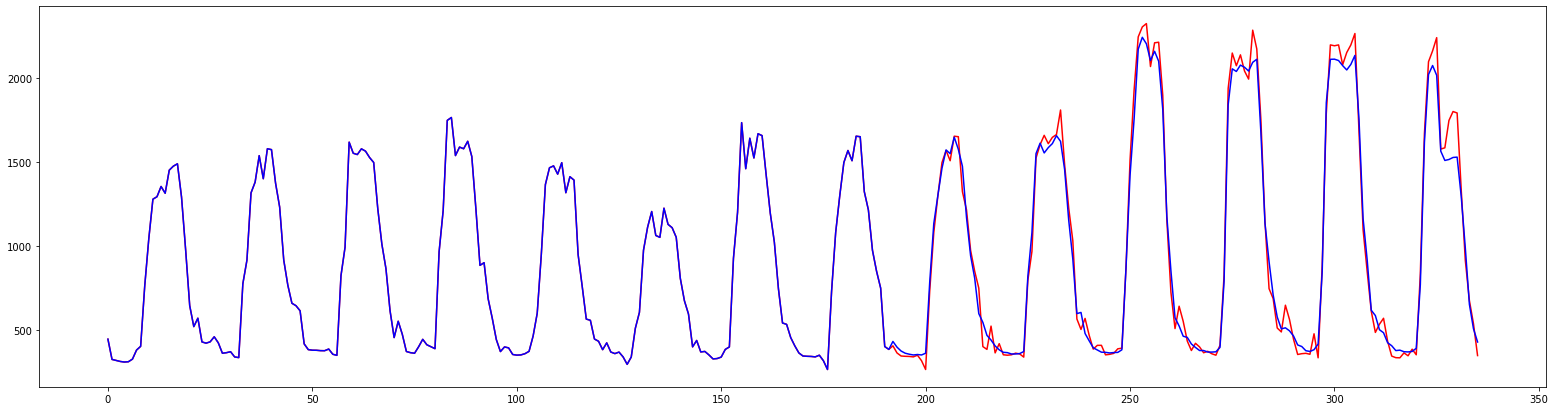

now : 4, sMAPE score : 6.099886792403082


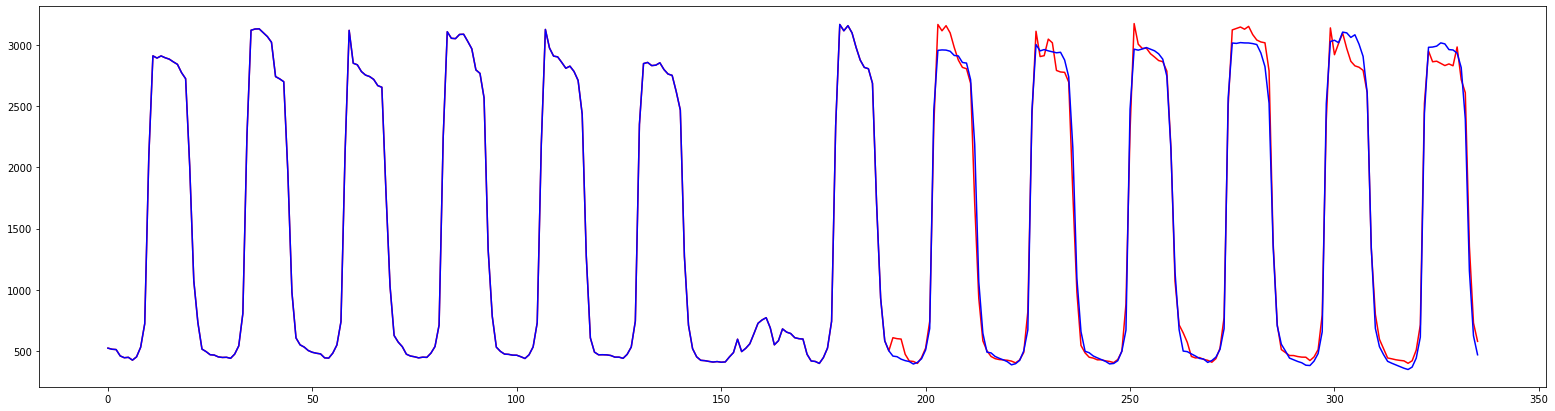

now : 10, sMAPE score : 5.6059424866126175


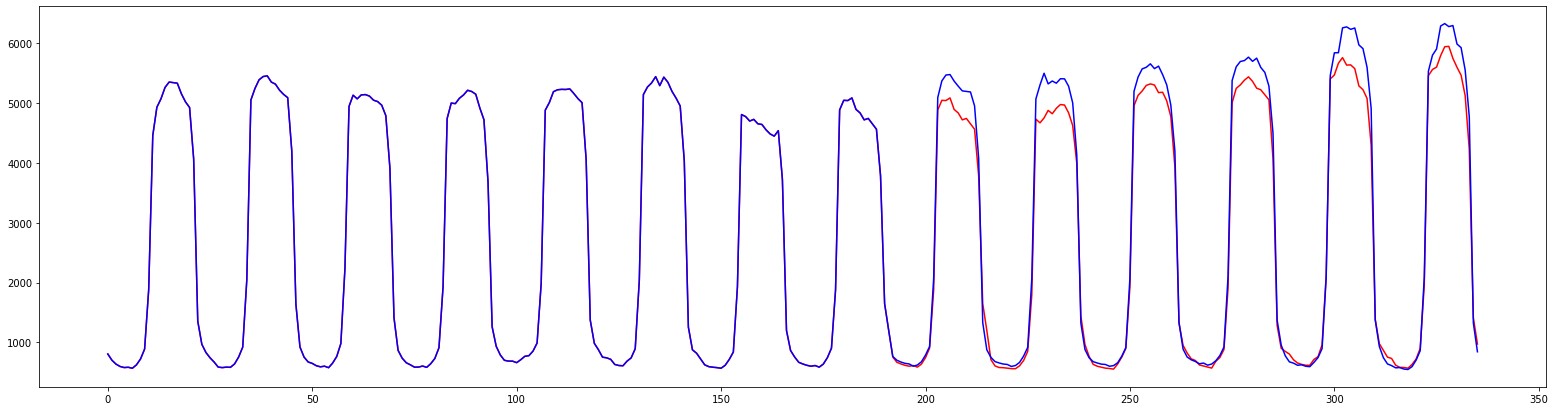

now : 11, sMAPE score : 6.287775234381384


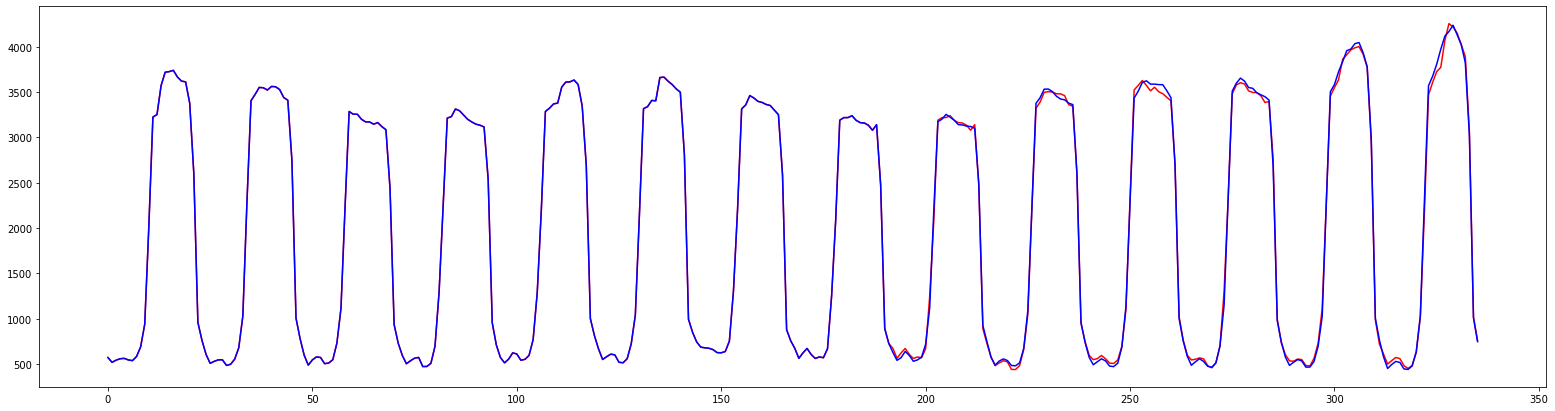

now : 12, sMAPE score : 2.436550739734416


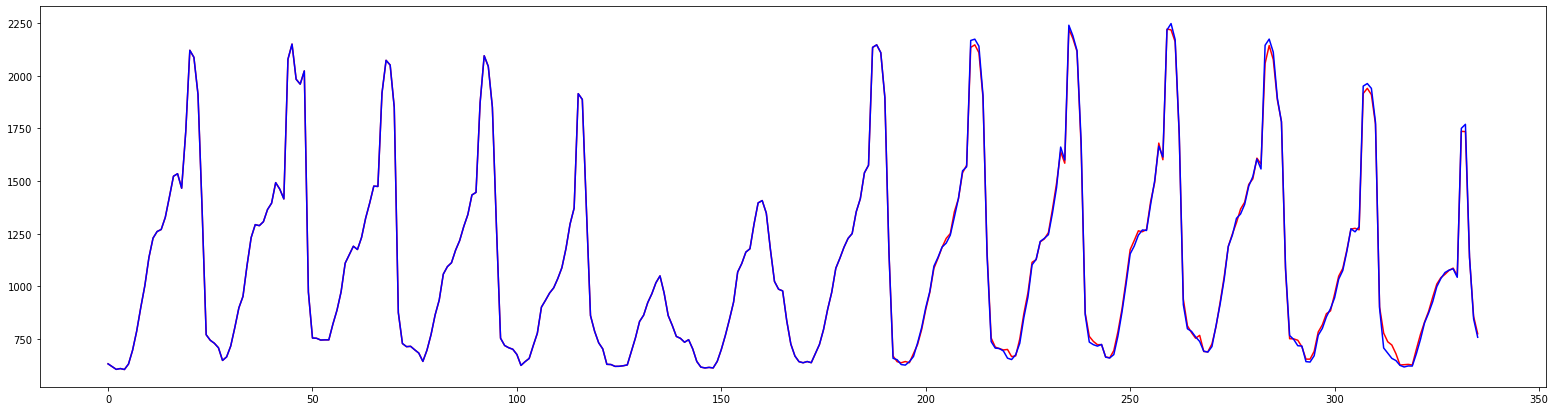

now : 34, sMAPE score : 1.2291816341569606


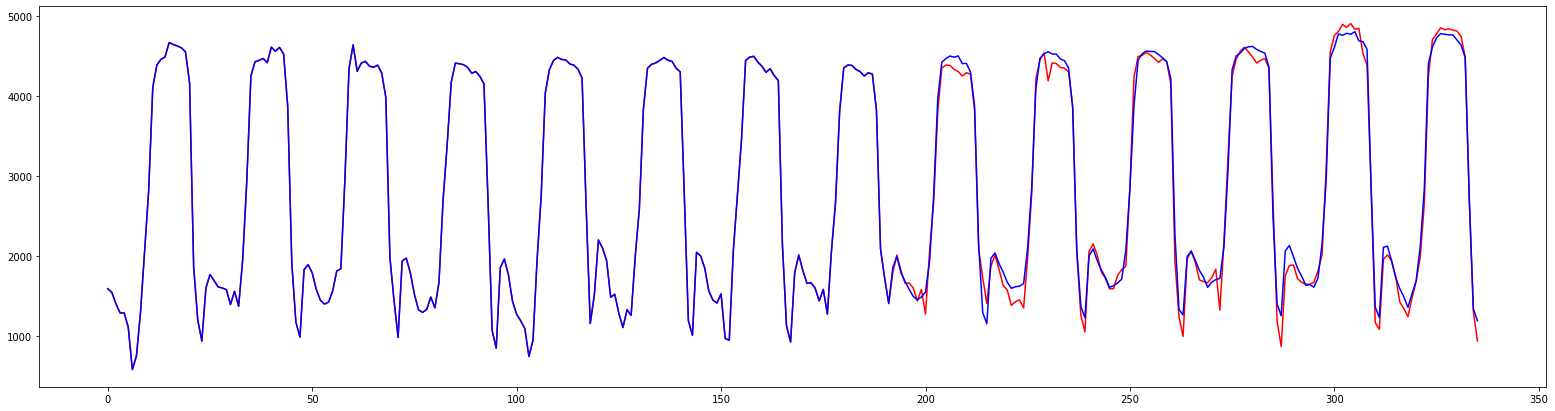

now : 40, sMAPE score : 4.388191569440005


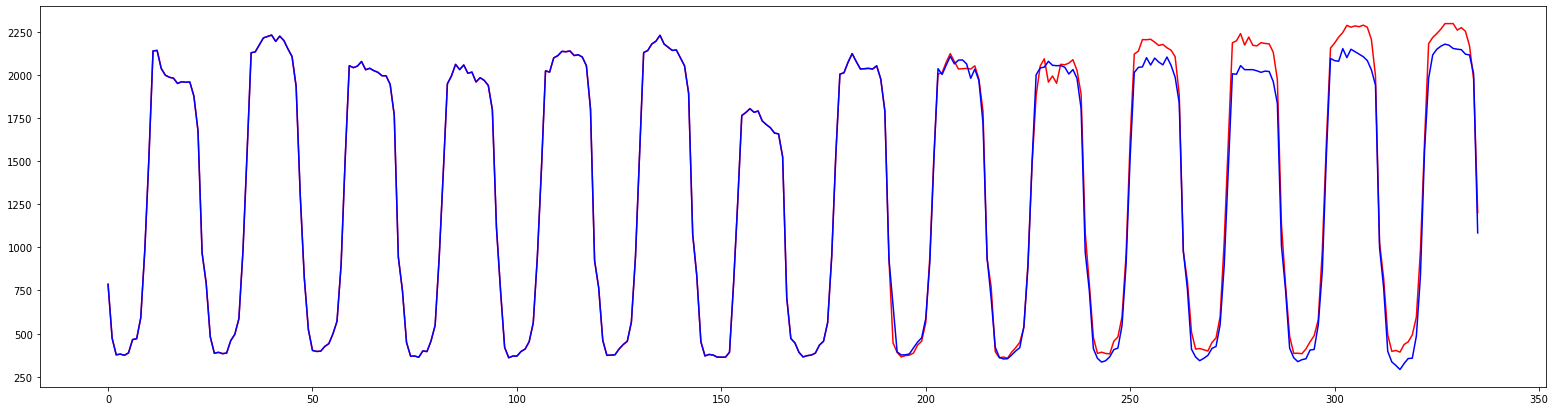

now : 41, sMAPE score : 6.357375866858861


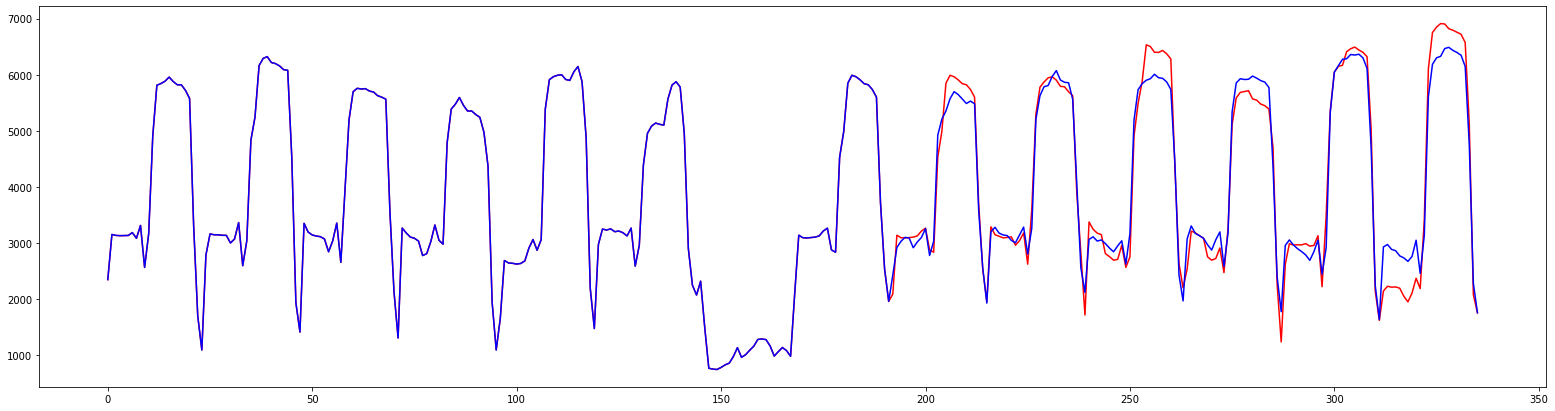

now : 42, sMAPE score : 5.804026325617797


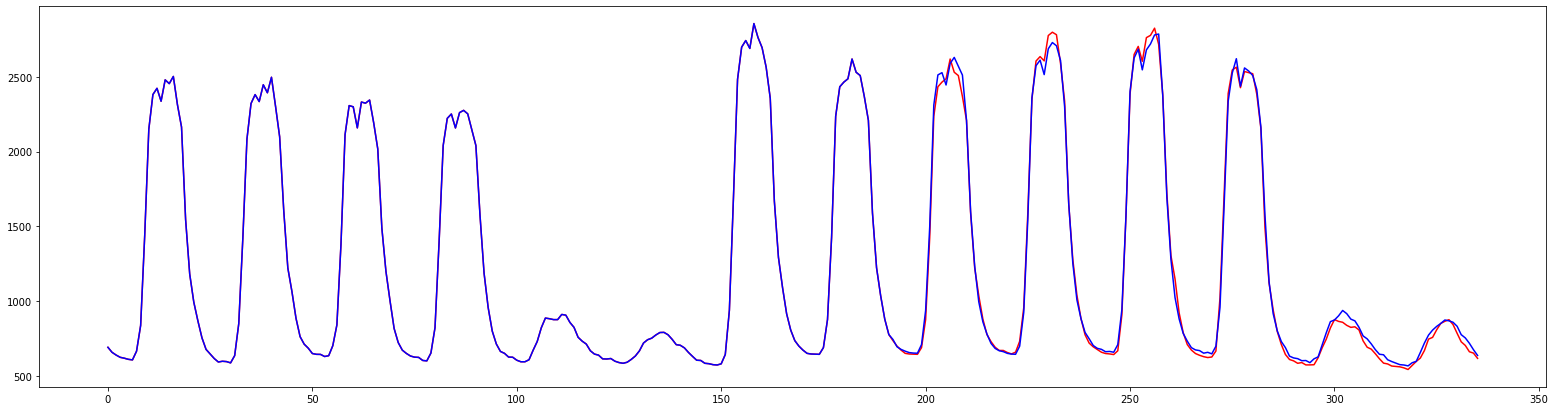

now : 6, sMAPE score : 2.574343469787703


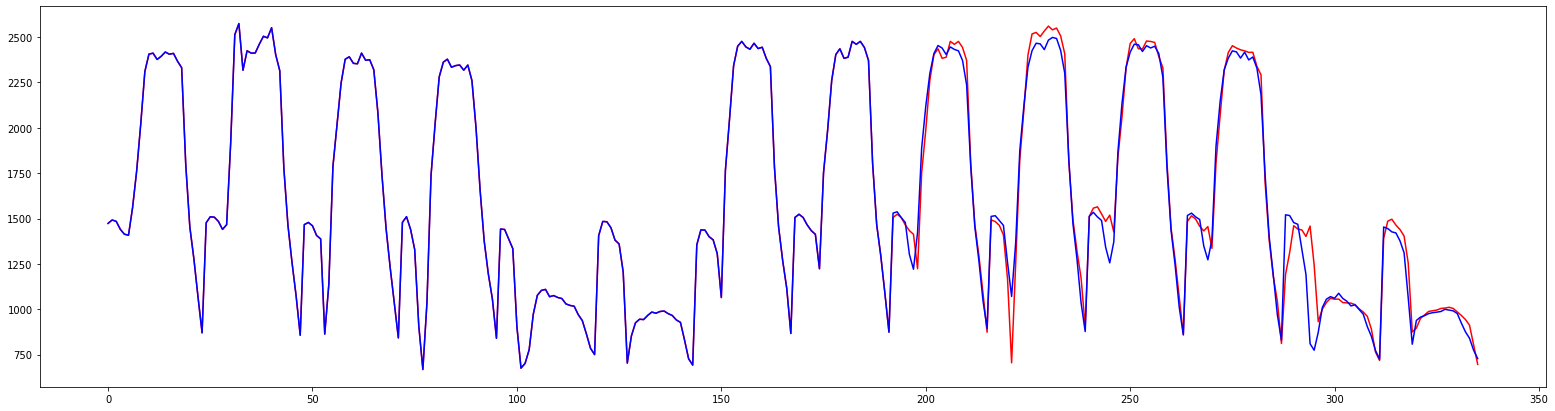

now : 7, sMAPE score : 3.7807500436430637


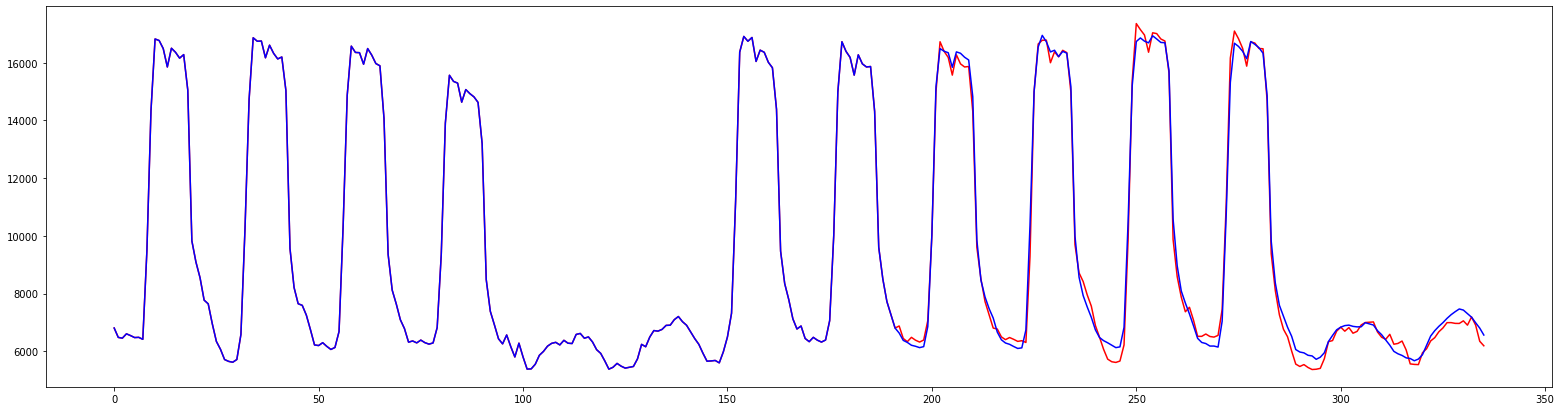

now : 8, sMAPE score : 2.7715561708347494


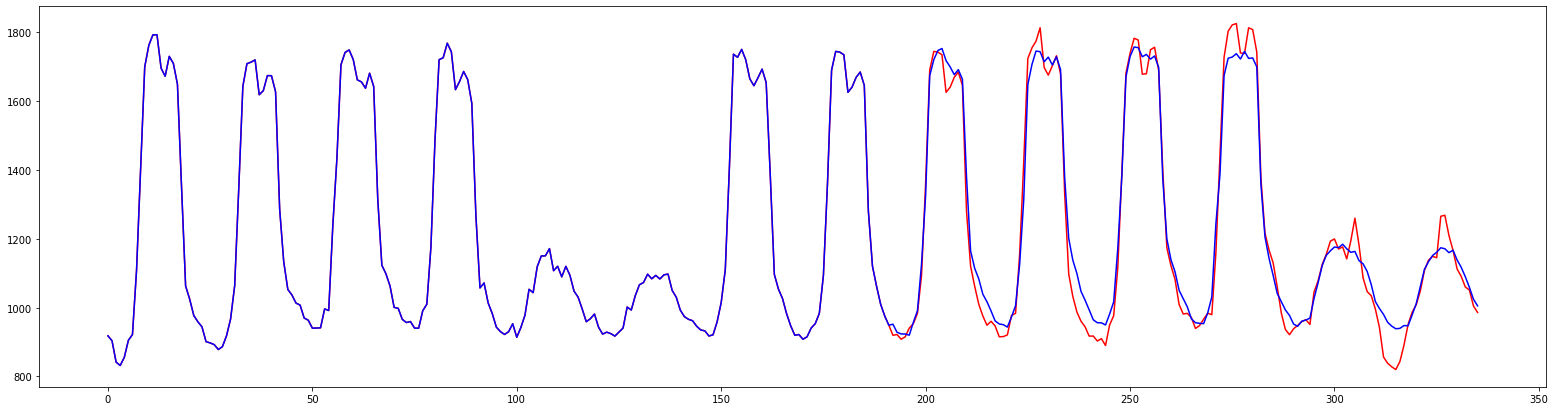

now : 13, sMAPE score : 2.7959049422865774


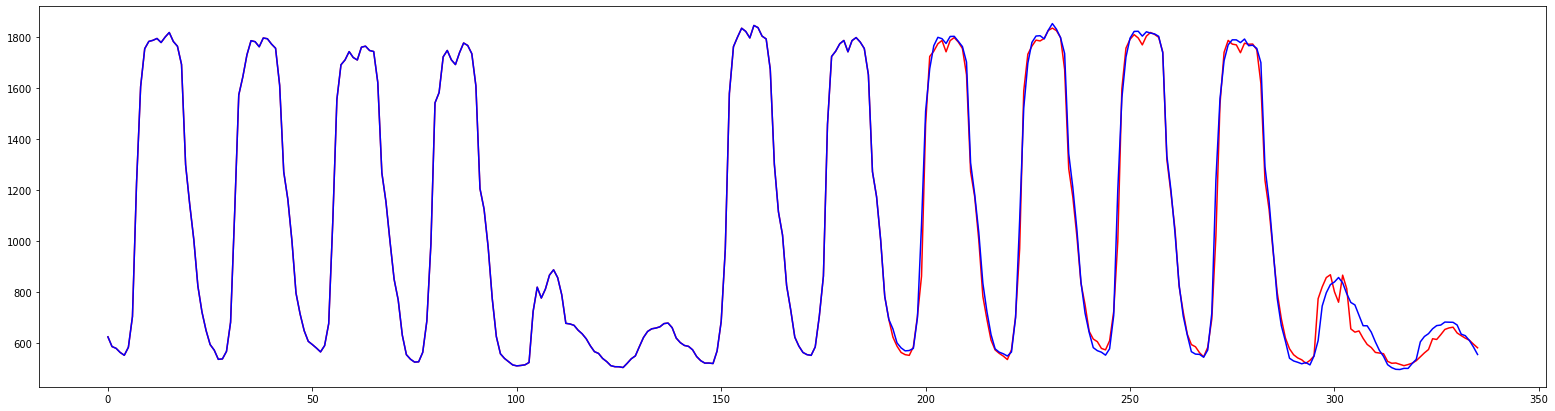

now : 17, sMAPE score : 3.0943058462242075


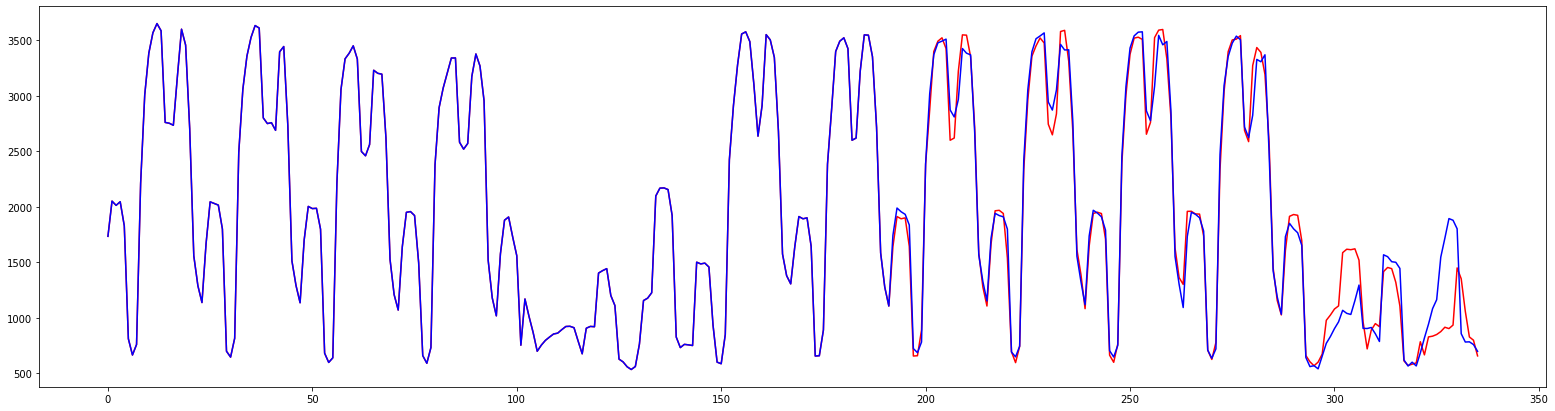

now : 18, sMAPE score : 7.614328736750307


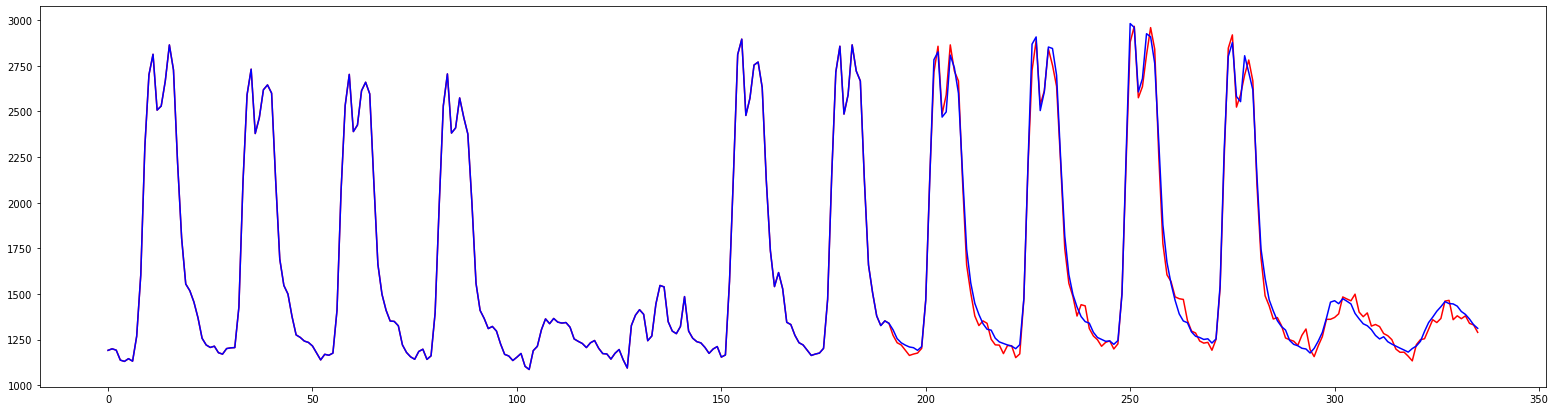

now : 25, sMAPE score : 2.0902590604675555


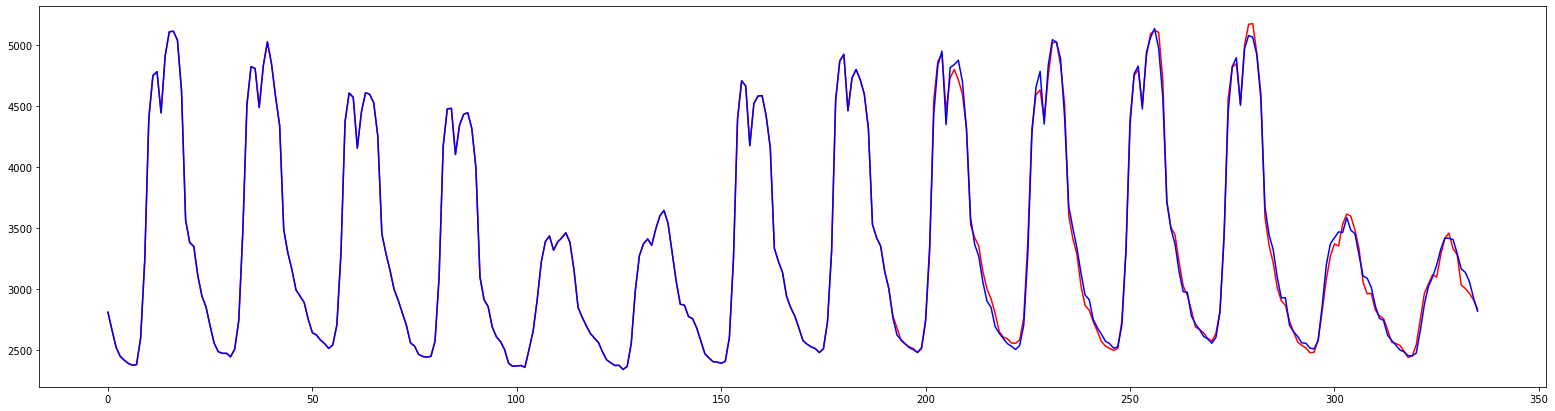

now : 26, sMAPE score : 1.2753828835436942


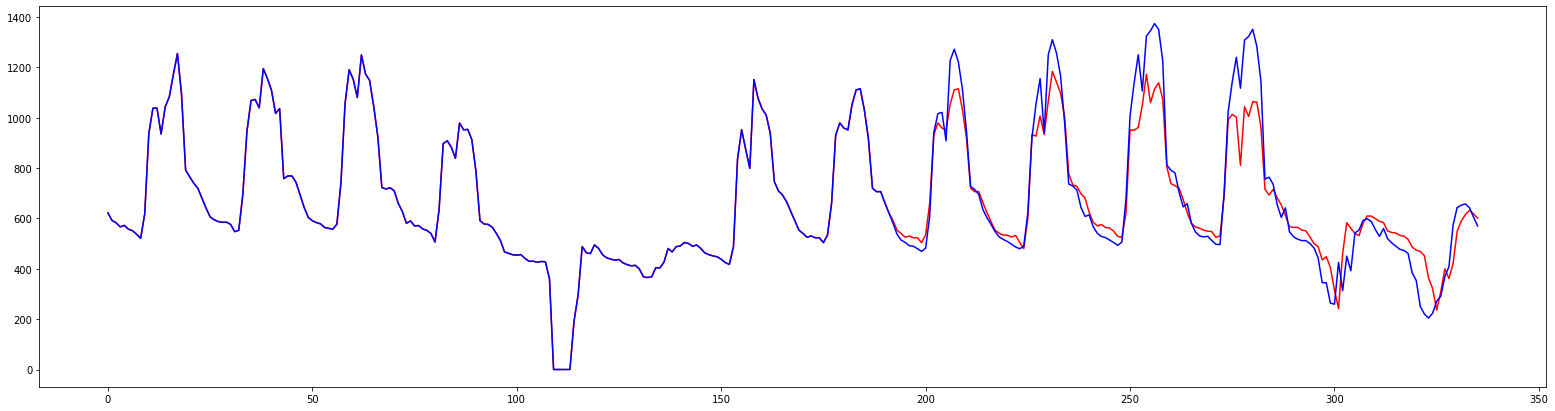

now : 27, sMAPE score : 9.267527846982587


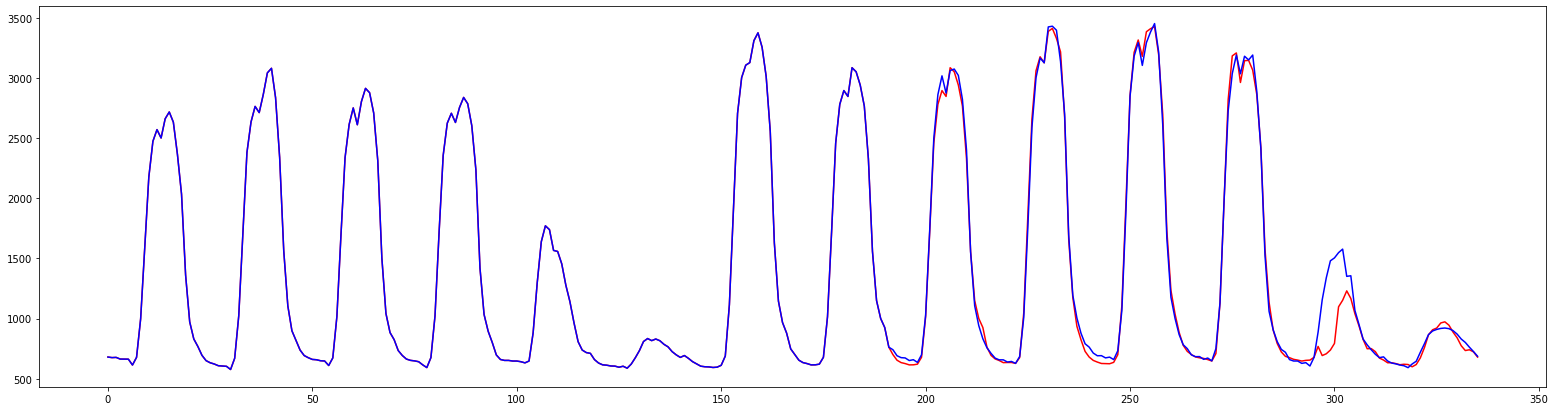

now : 35, sMAPE score : 4.431417972204501


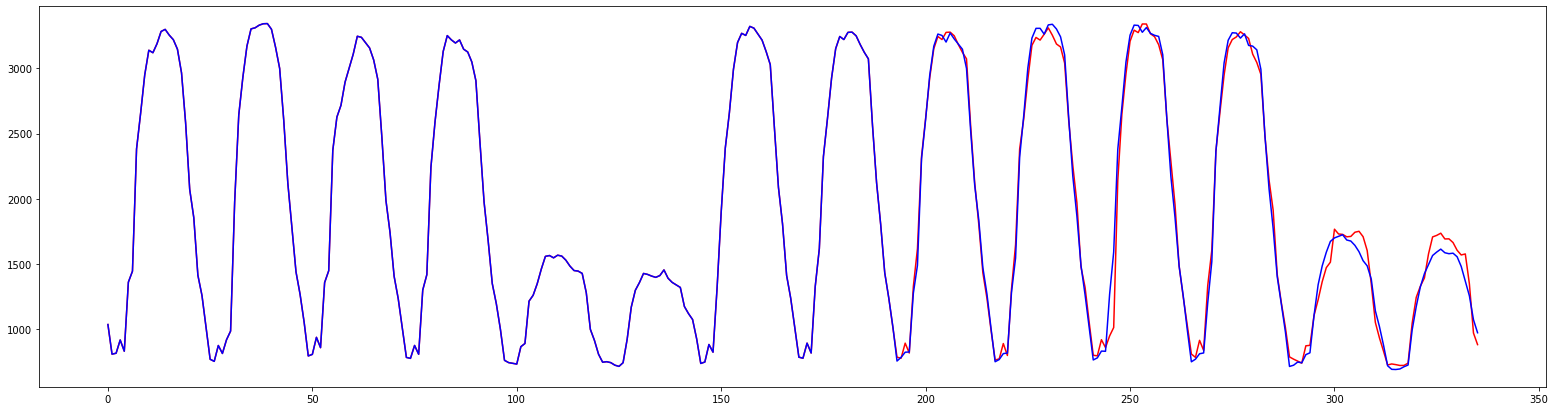

now : 46, sMAPE score : 3.4901459530259165


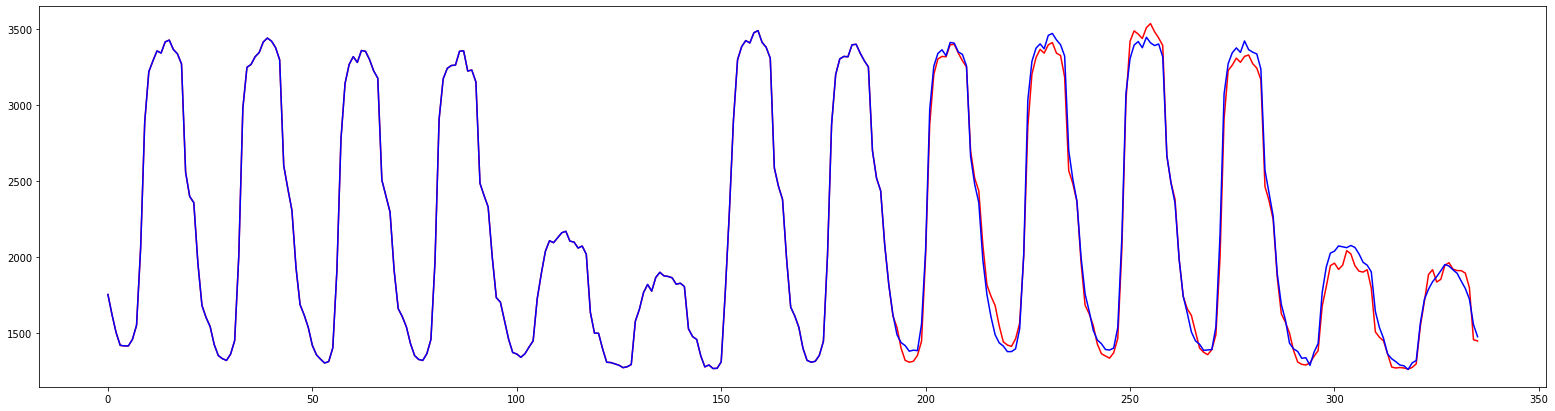

now : 47, sMAPE score : 2.443511663218401


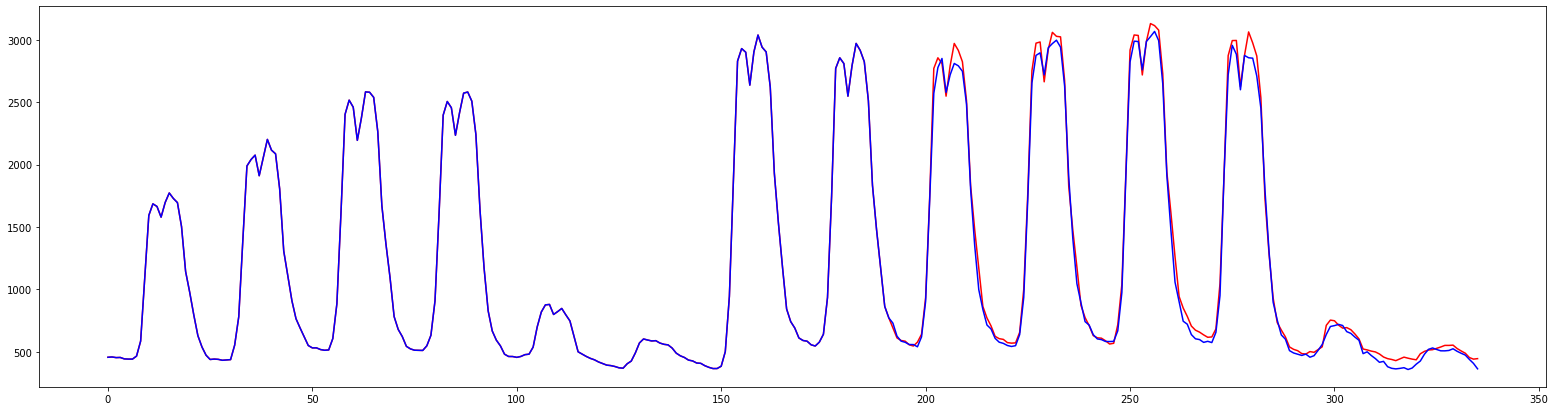

now : 48, sMAPE score : 4.568552644857766


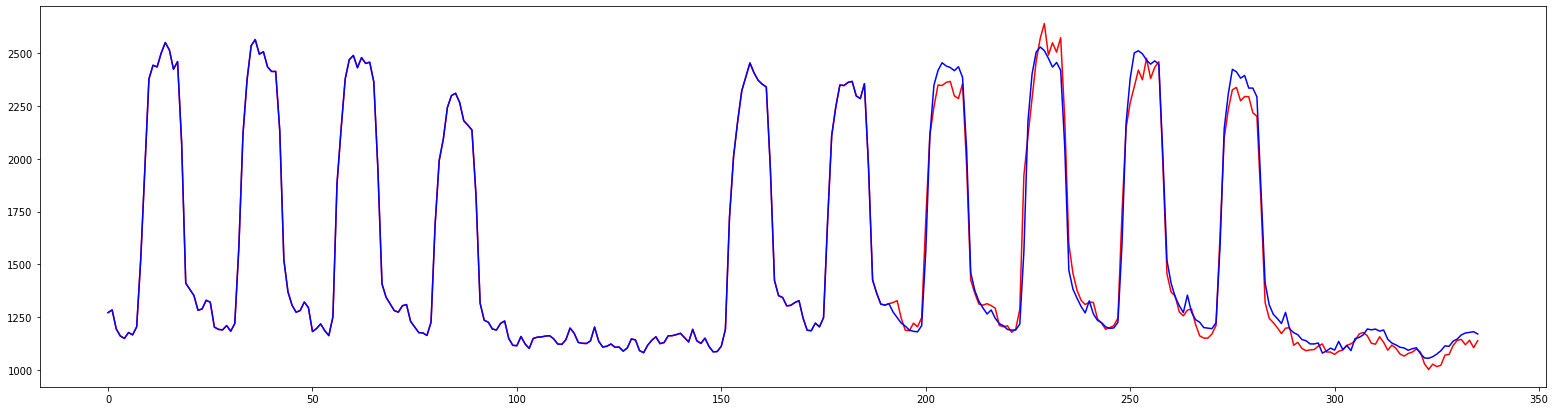

now : 53, sMAPE score : 2.689583288411471


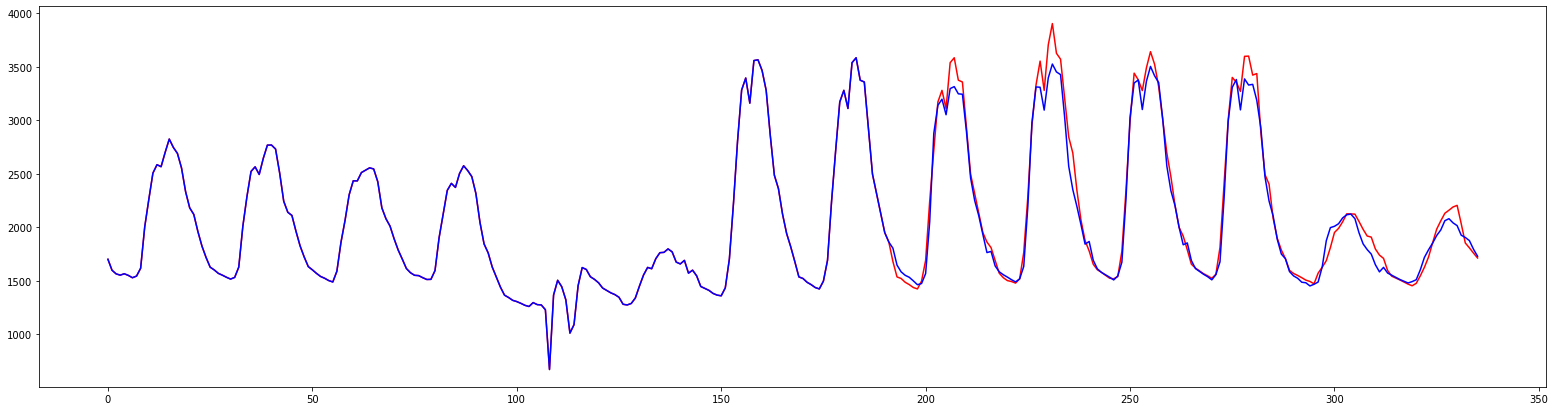

now : 55, sMAPE score : 2.9278285416898804


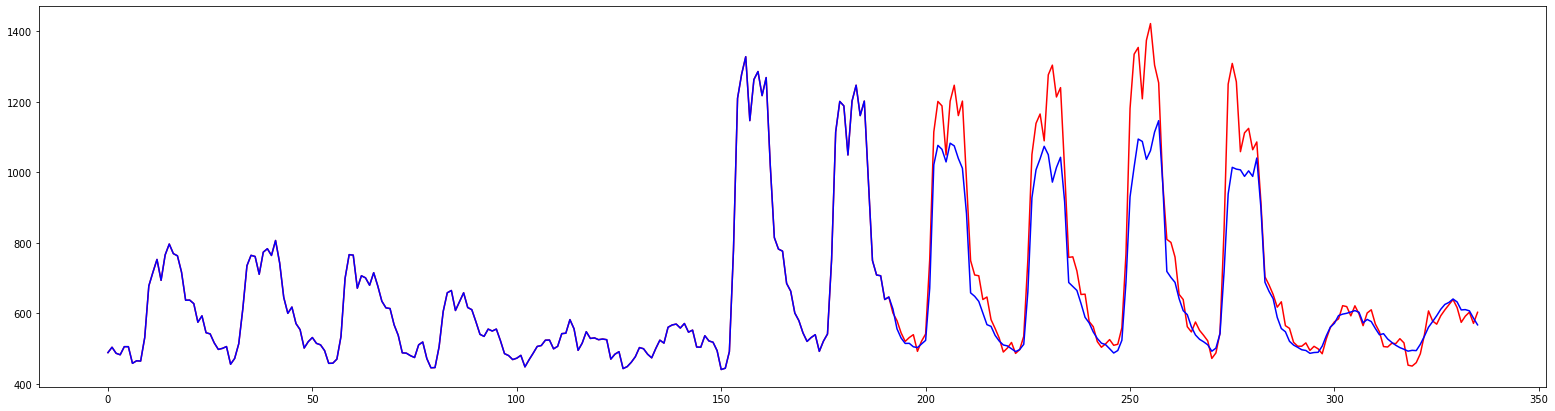

now : 56, sMAPE score : 5.855832352458252


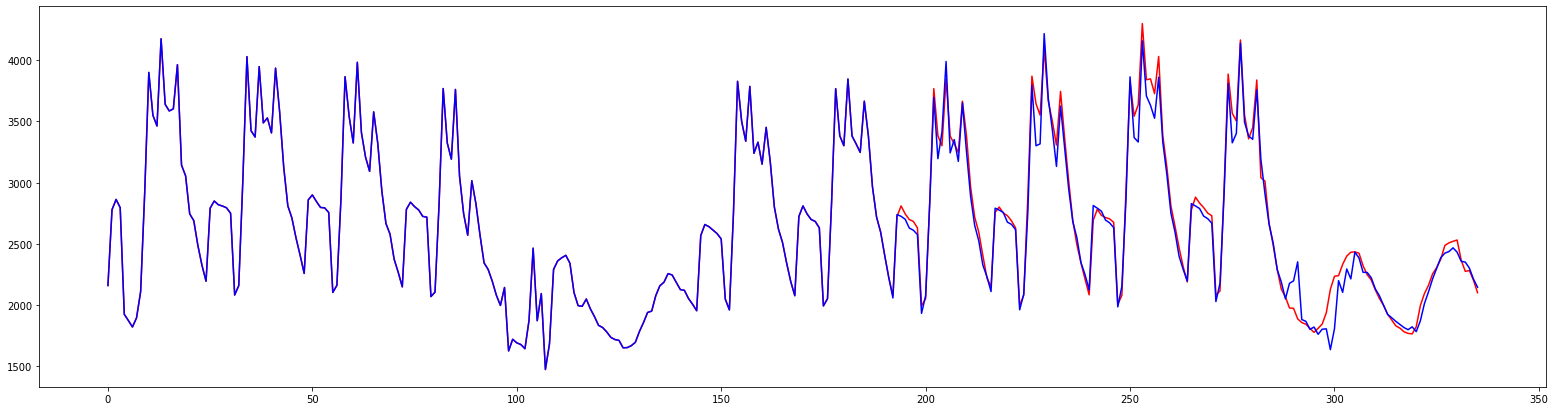

now : 57, sMAPE score : 2.503873292135525


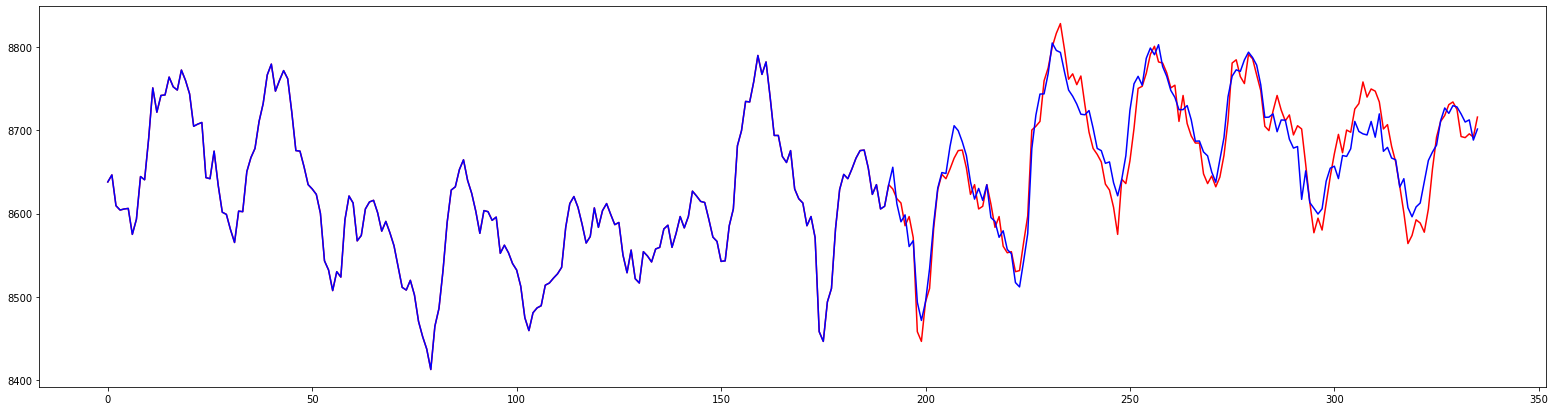

now : 1, sMAPE score : 0.1917177152828466


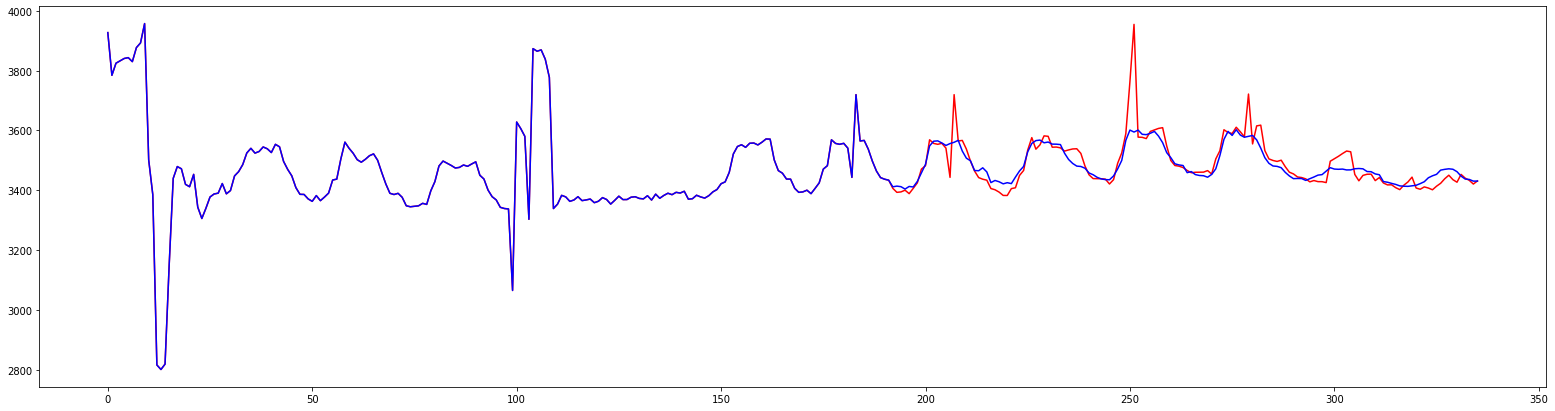

now : 3, sMAPE score : 0.6021710500009019


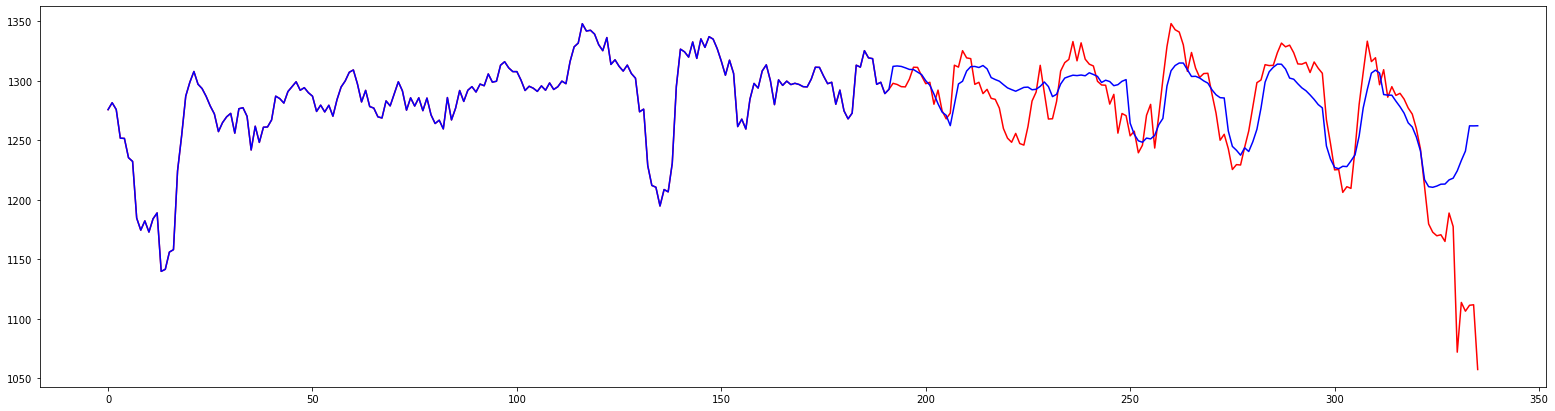

now : 9, sMAPE score : 1.5960436637685986


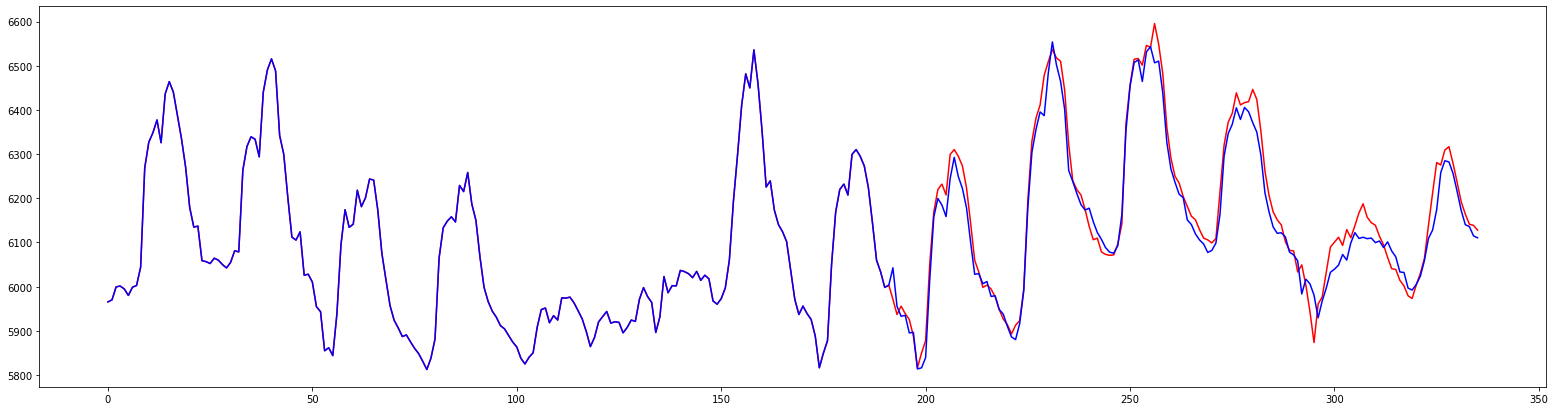

now : 31, sMAPE score : 0.39273909967123555


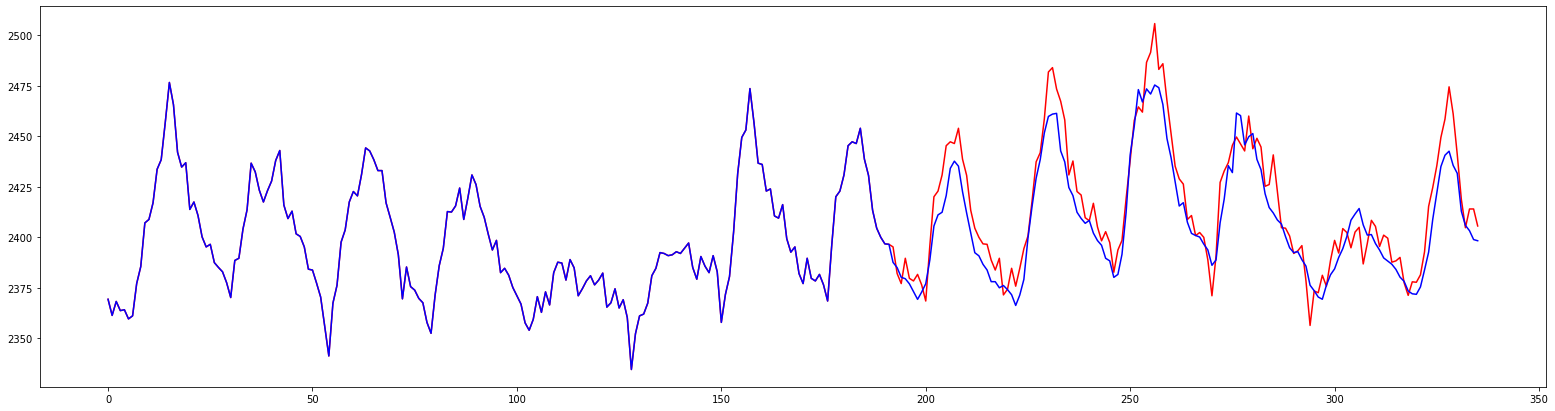

now : 32, sMAPE score : 0.34729159770845214


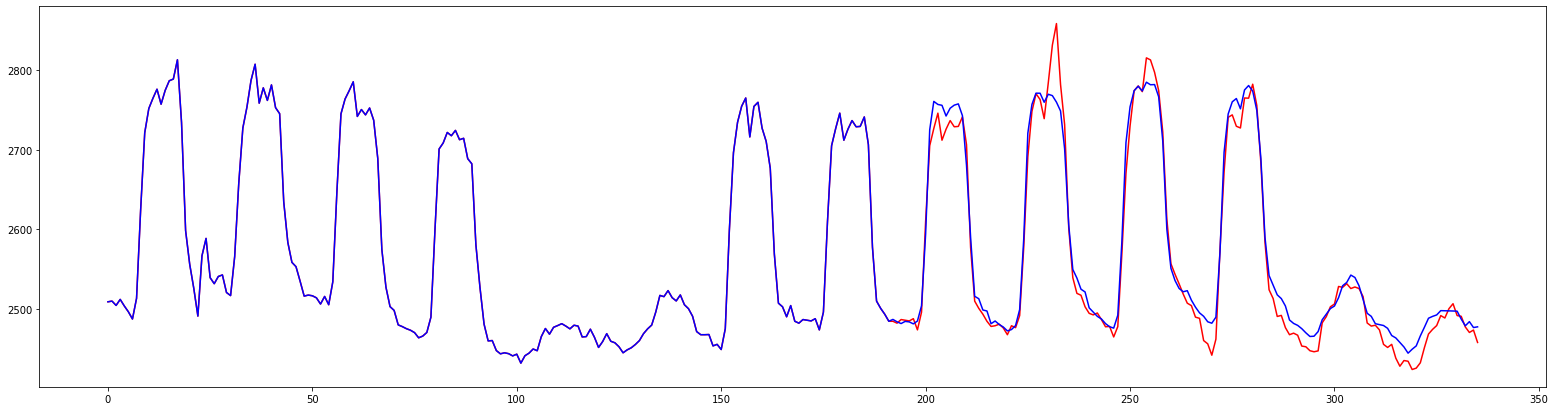

now : 33, sMAPE score : 0.4697118249973349


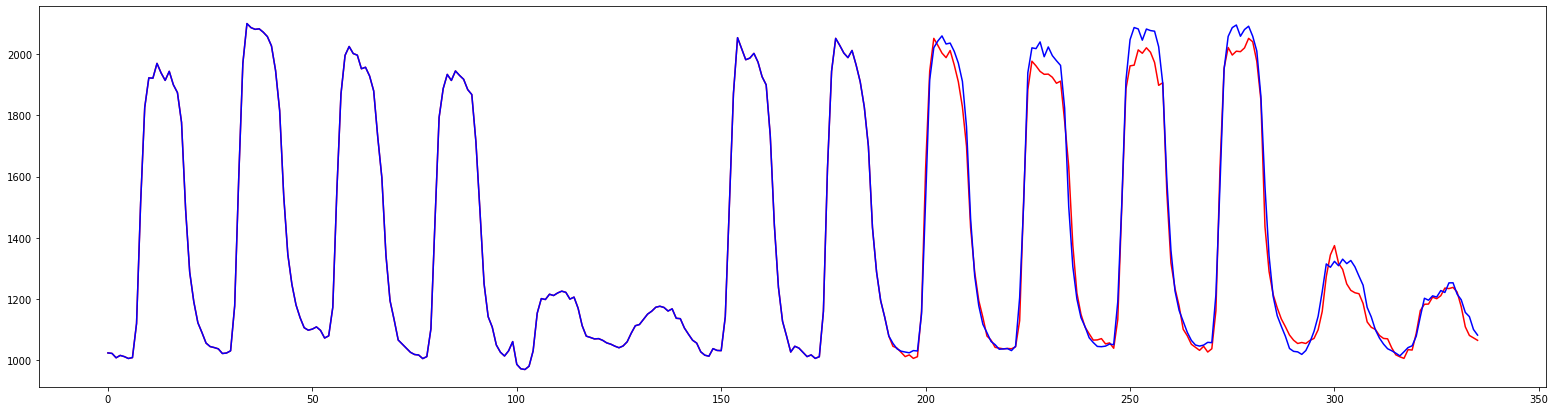

now : 2, sMAPE score : 2.0176910509069548


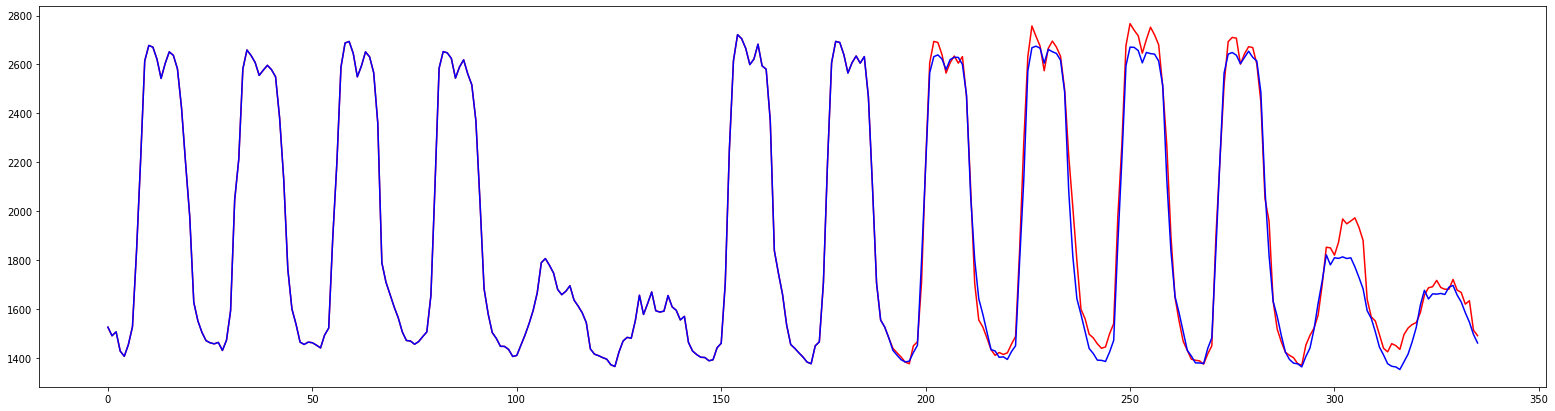

now : 14, sMAPE score : 2.2786303704098434


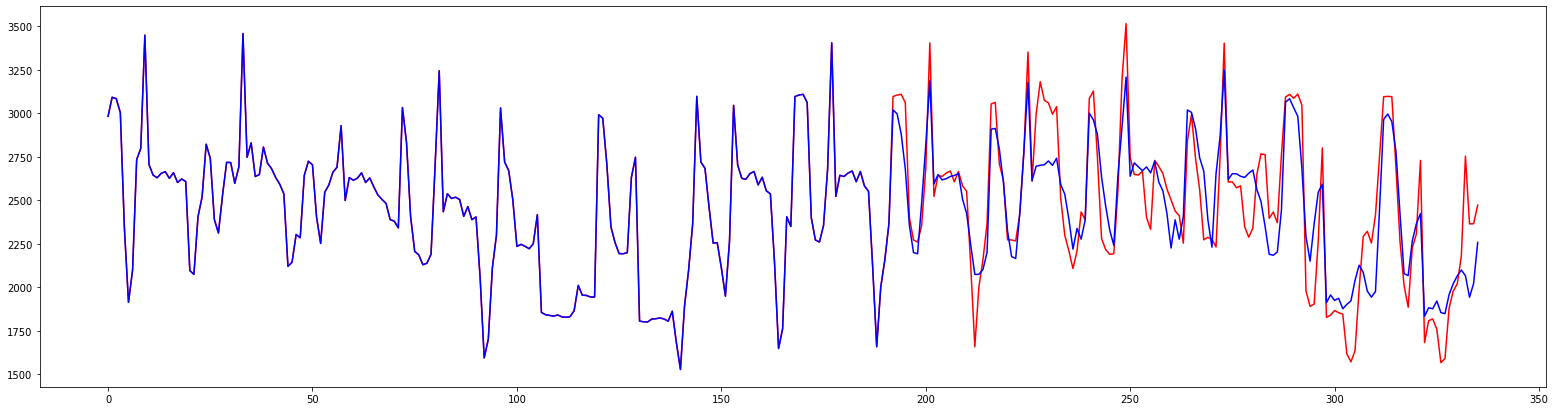

now : 15, sMAPE score : 6.025498774267037


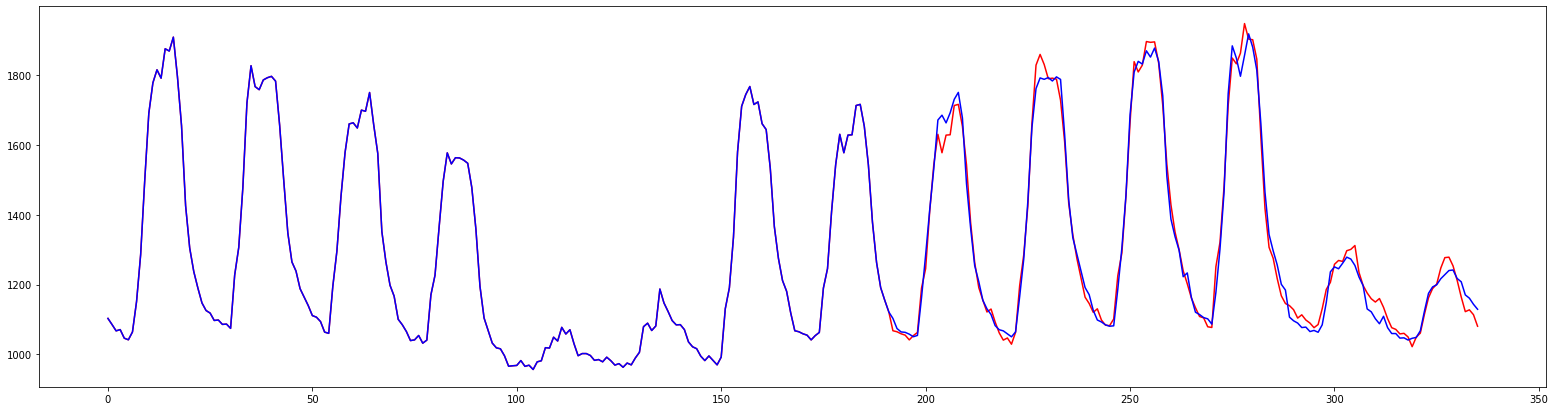

now : 22, sMAPE score : 1.5670818759111307


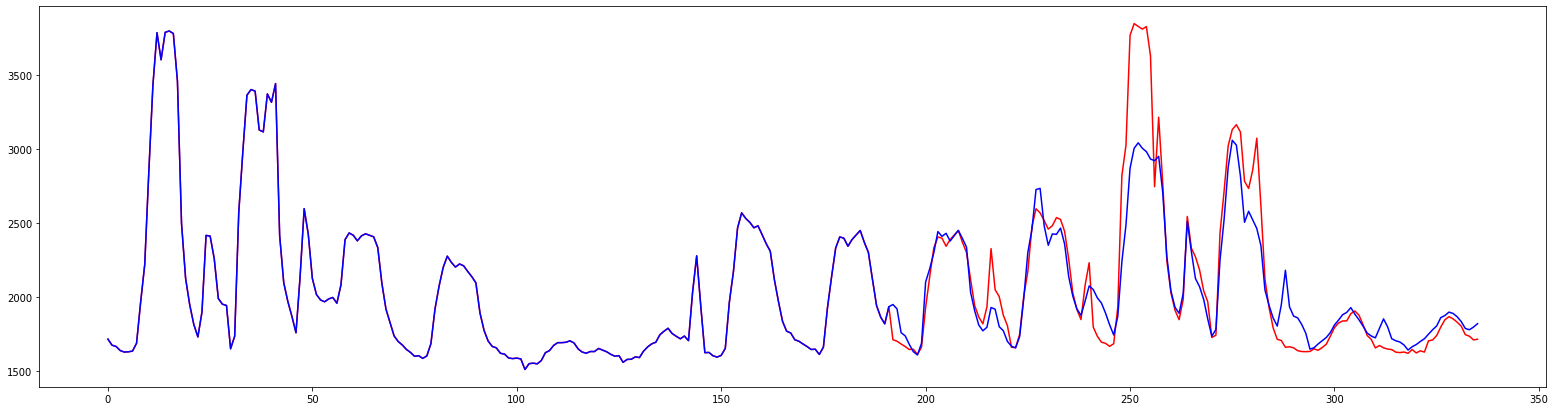

now : 23, sMAPE score : 4.929775236705732


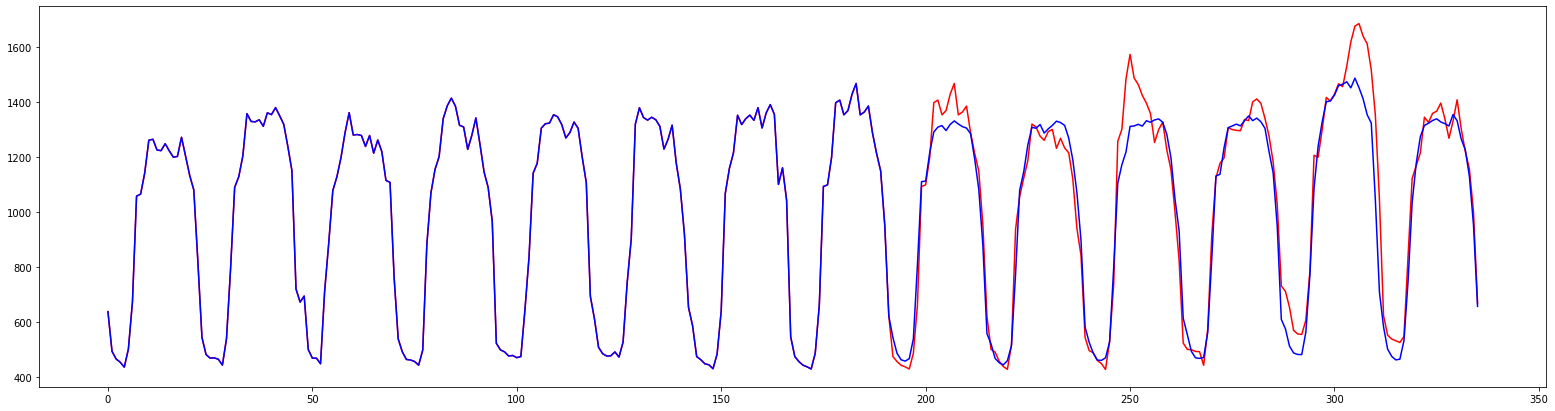

now : 29, sMAPE score : 5.534558809507768


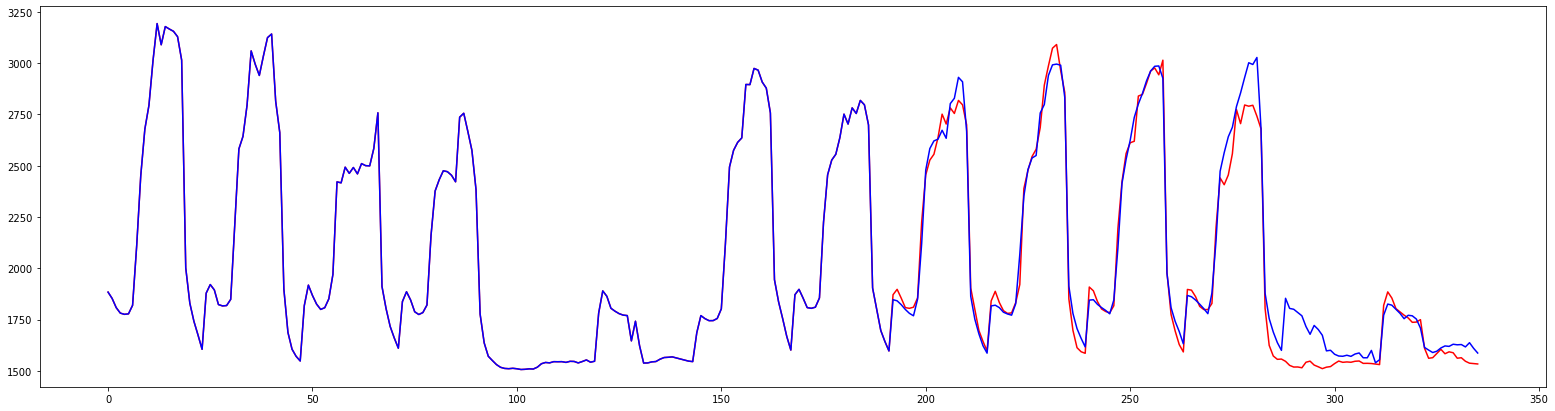

now : 37, sMAPE score : 2.7081816821143097


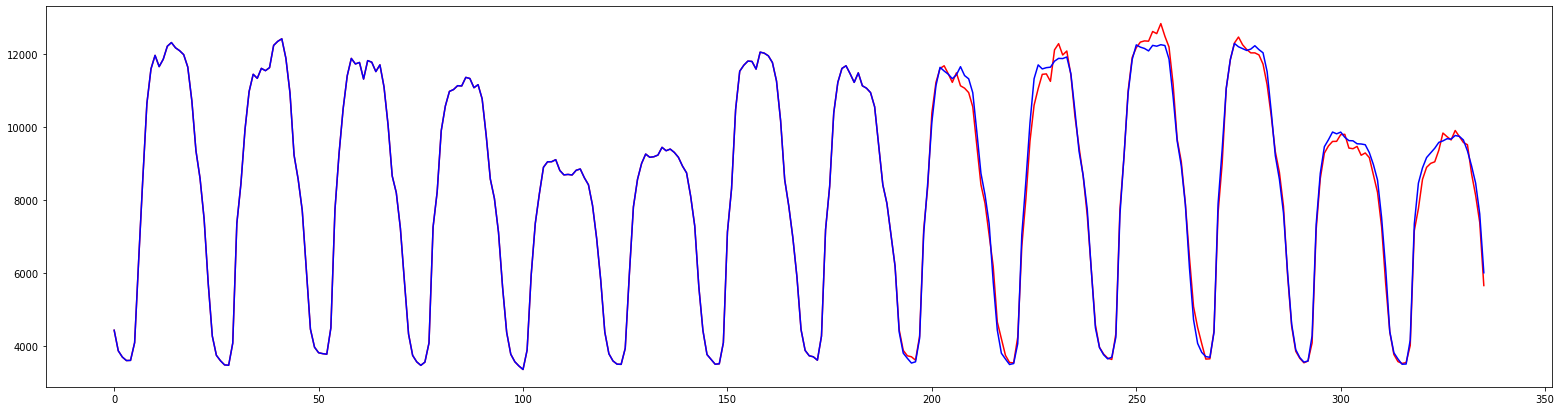

now : 38, sMAPE score : 2.001891901449386


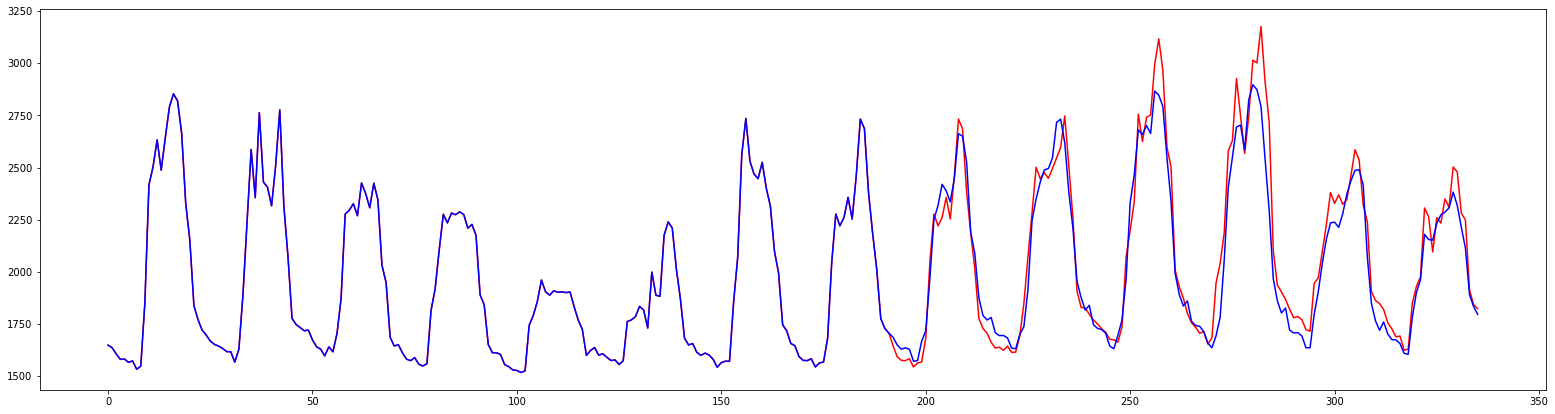

now : 39, sMAPE score : 3.1400497731789736


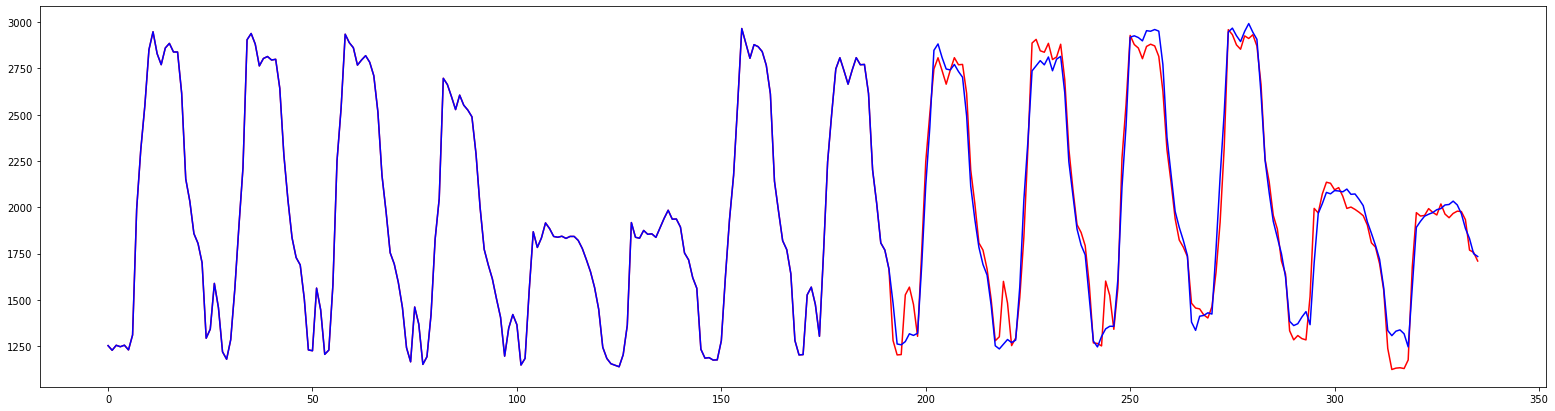

now : 43, sMAPE score : 3.587812802929427


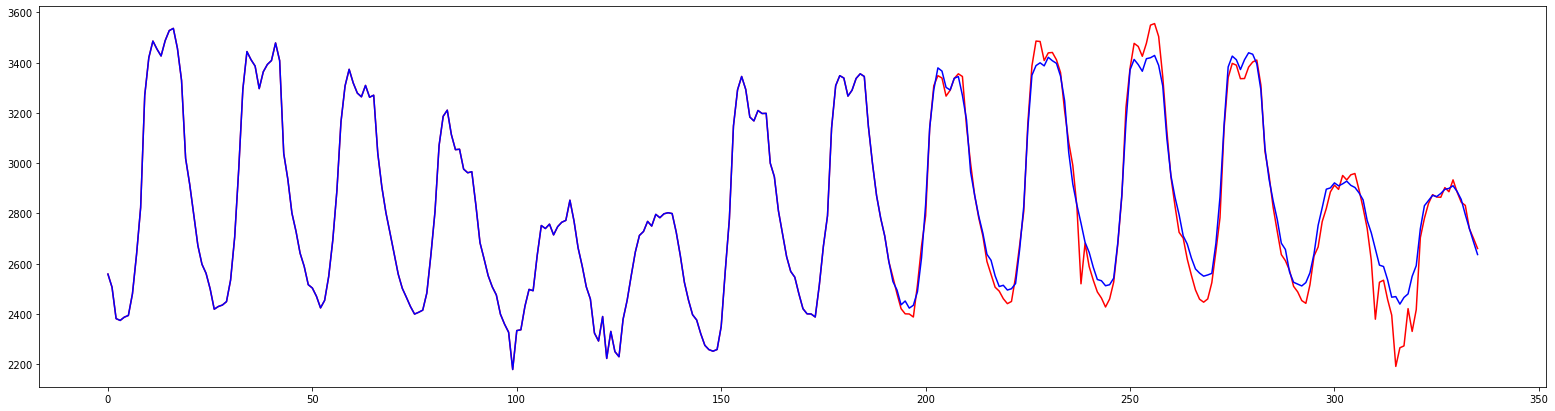

now : 44, sMAPE score : 1.49691195529386


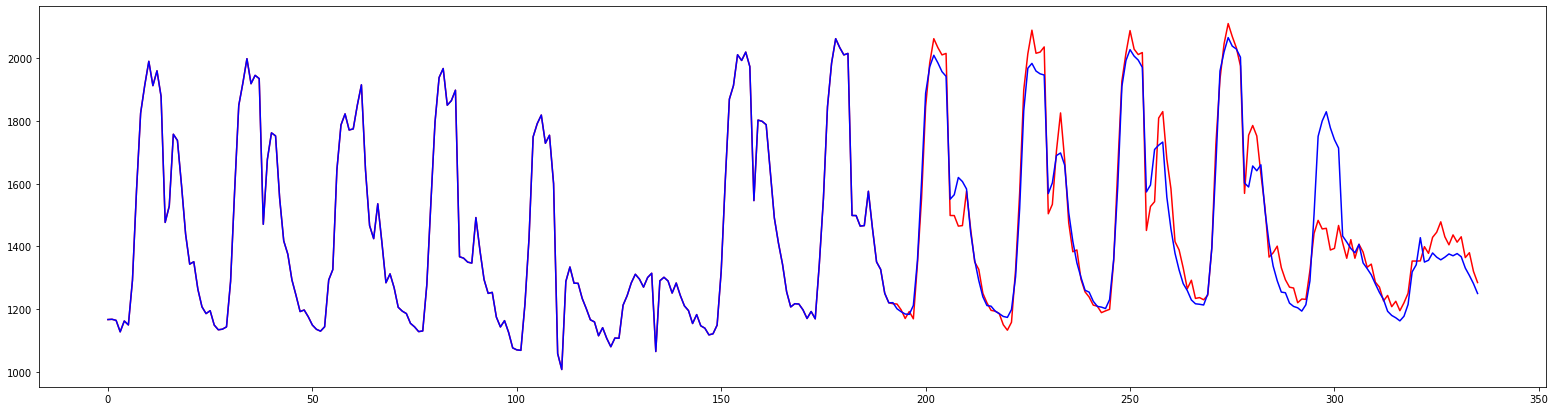

now : 45, sMAPE score : 3.1001351479223094


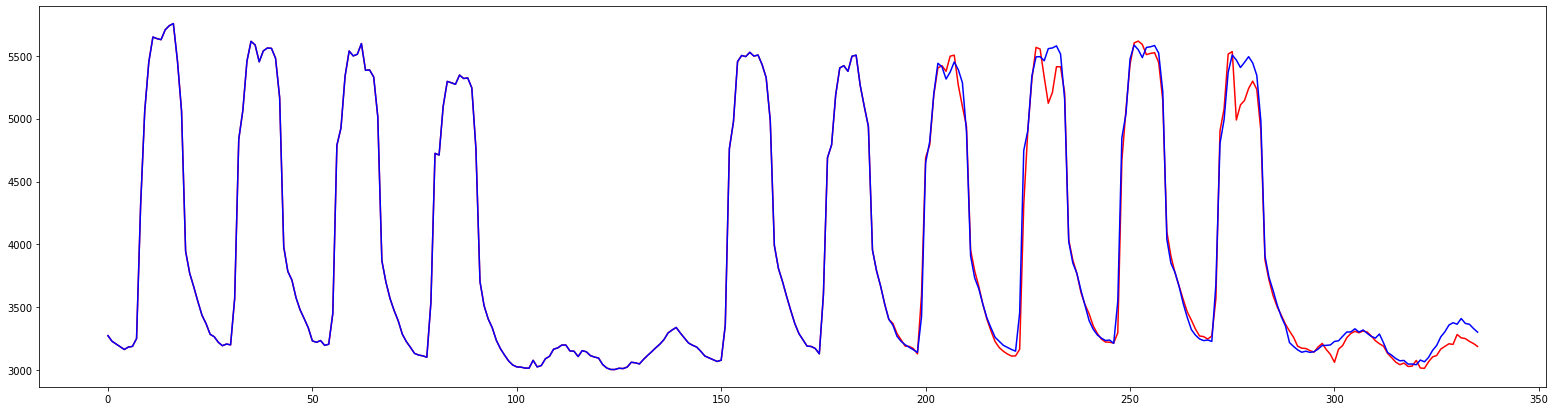

now : 52, sMAPE score : 1.4604388053690878


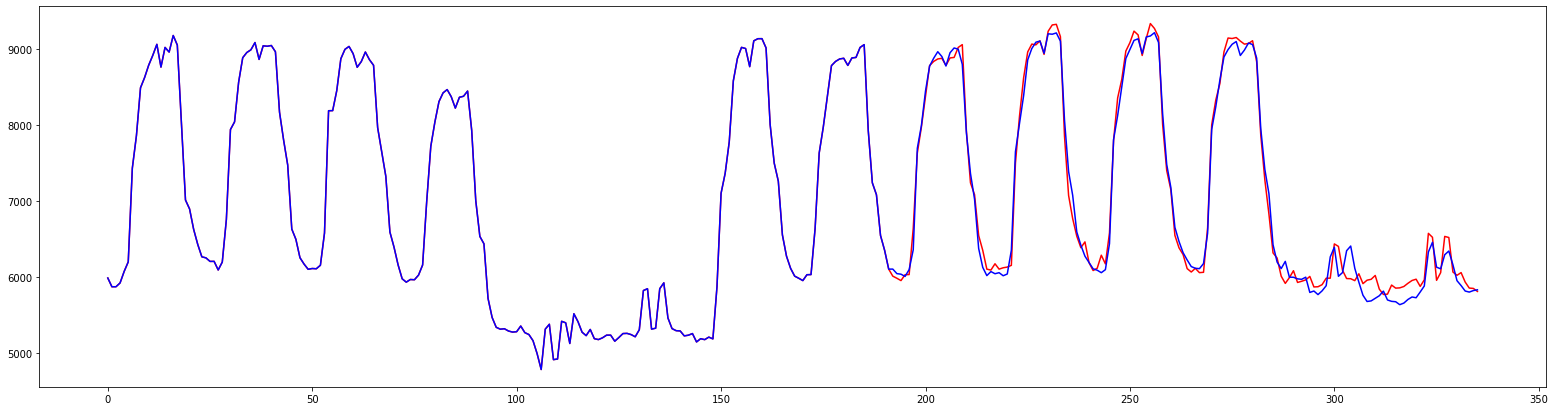

now : 54, sMAPE score : 1.44033874910843


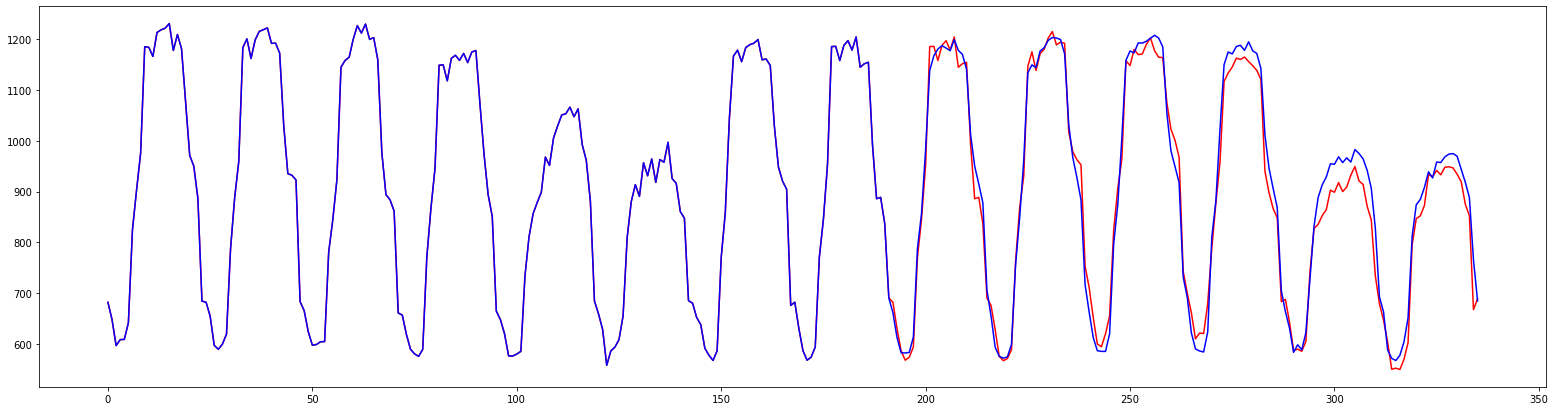

now : 58, sMAPE score : 2.7222406260166148


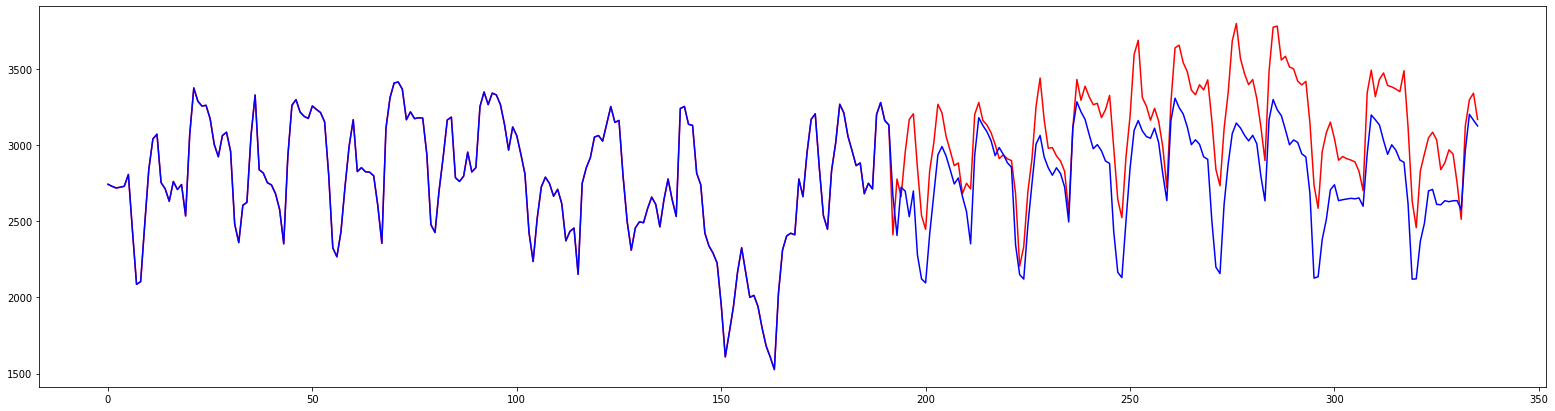

now : 5, sMAPE score : 8.995838200667883


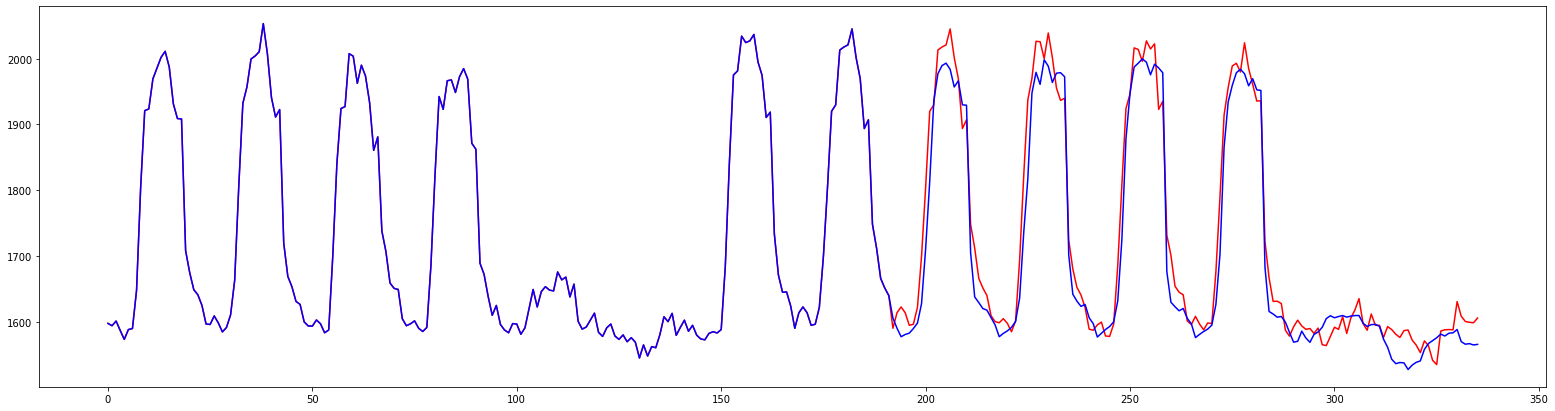

now : 16, sMAPE score : 1.3860033127159952


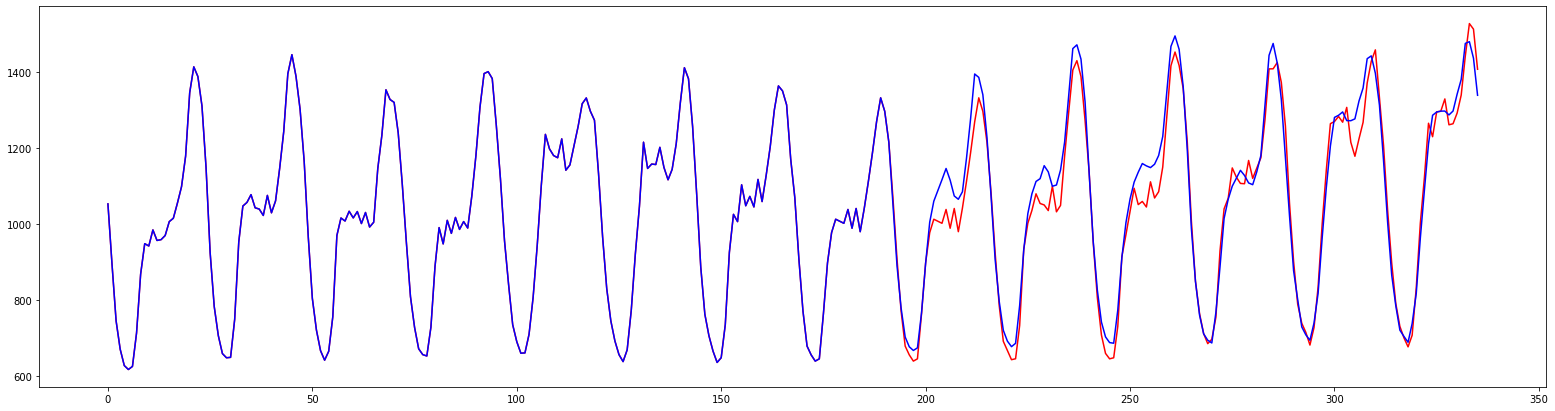

now : 19, sMAPE score : 3.052778274760193


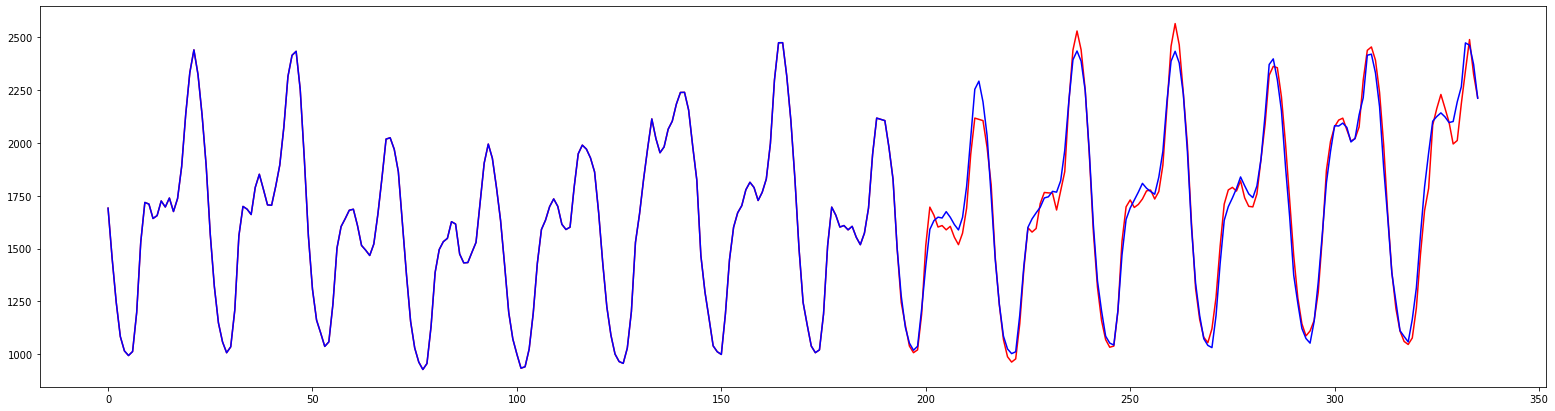

now : 20, sMAPE score : 2.366799596571944


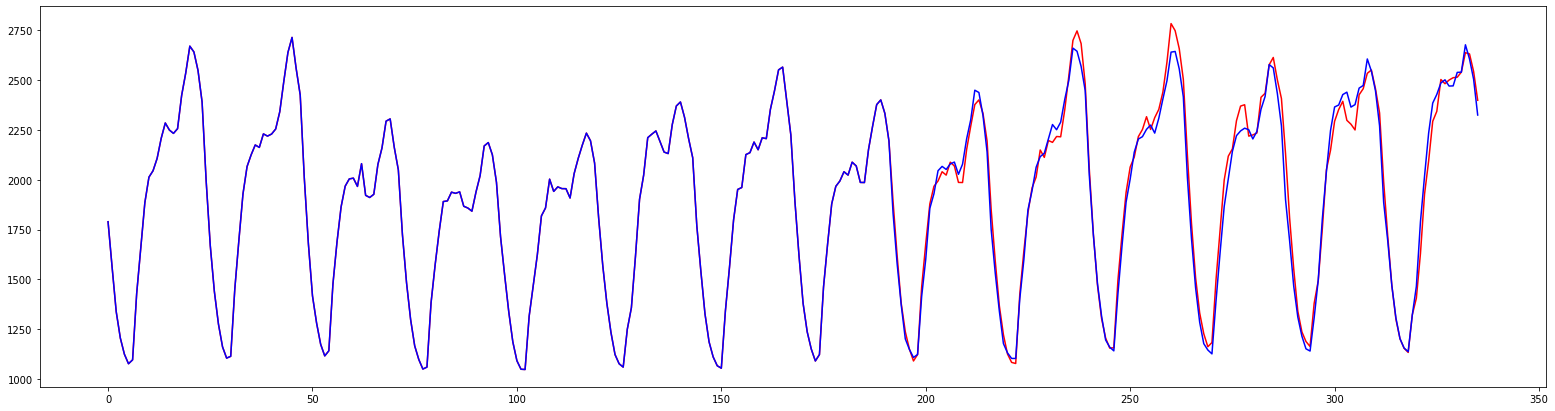

now : 21, sMAPE score : 2.1737323514855307


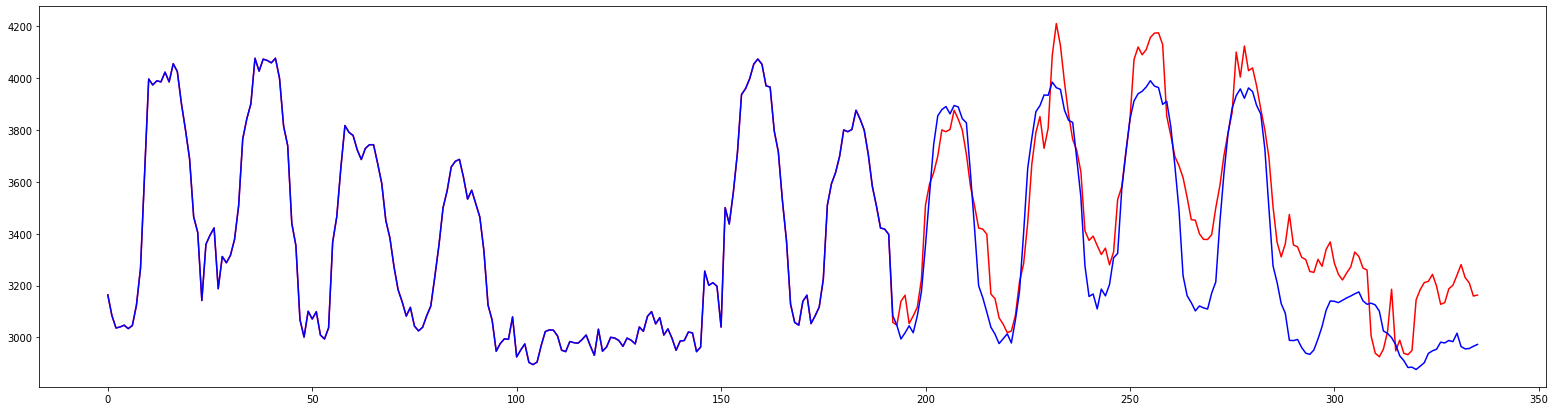

now : 24, sMAPE score : 3.9323263414940657


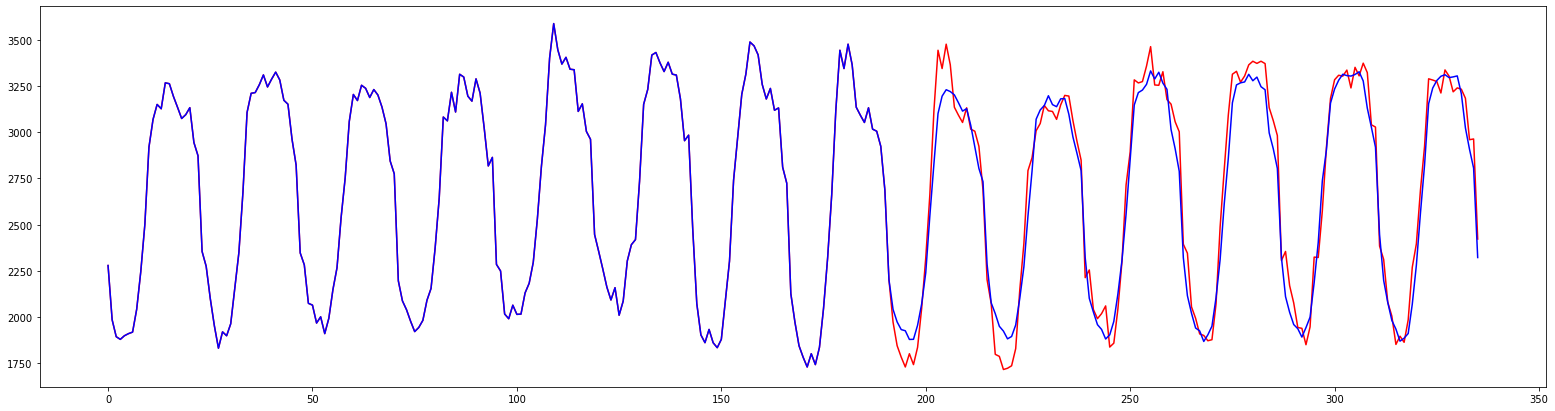

now : 28, sMAPE score : 3.150734785112022


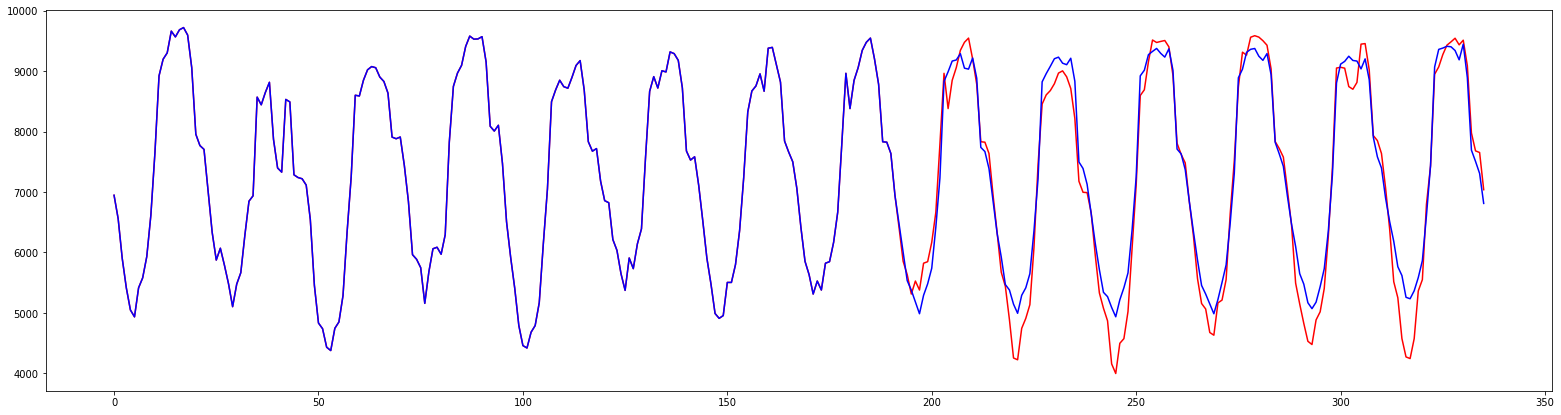

now : 30, sMAPE score : 4.132385130217848


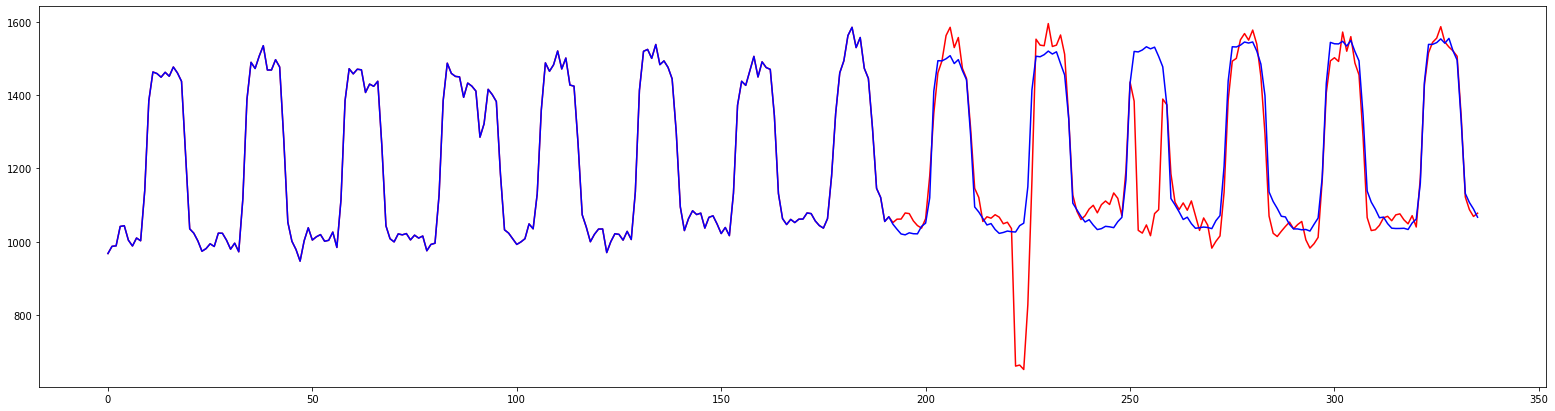

now : 36, sMAPE score : 4.651837246207815


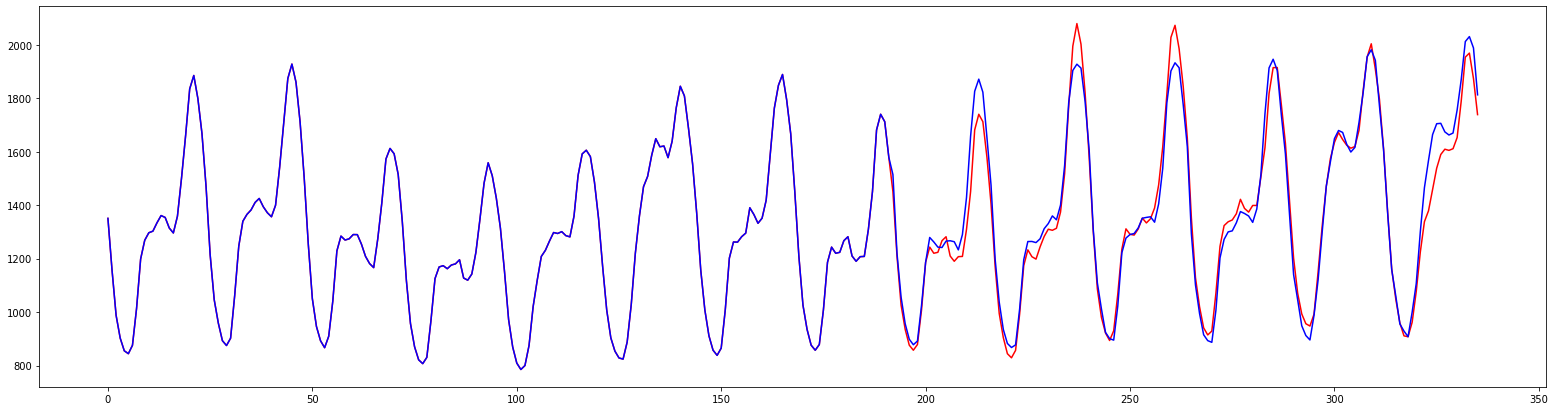

now : 49, sMAPE score : 2.7296824782413265


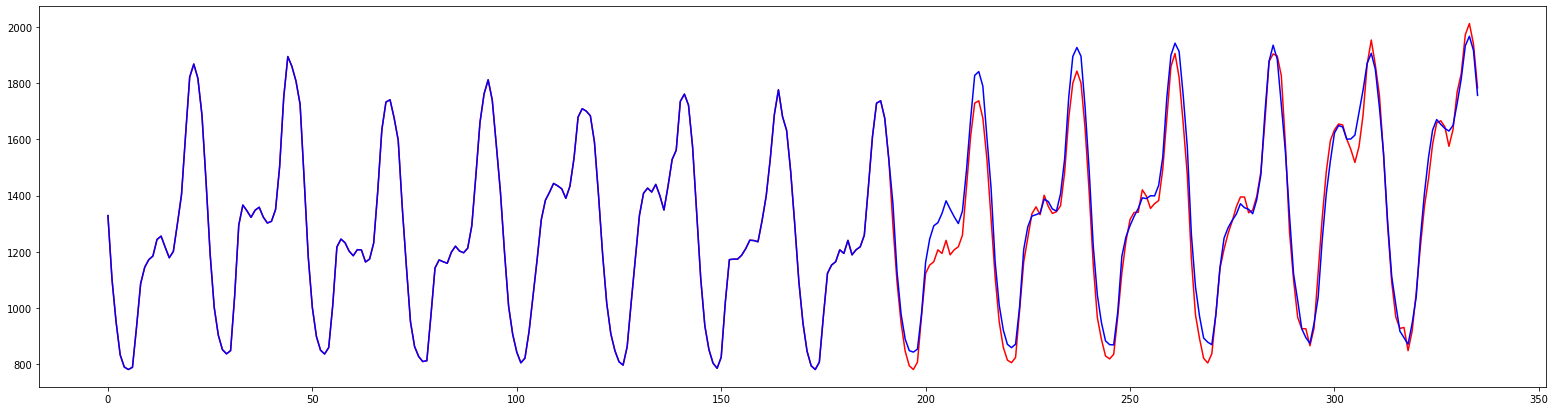

now : 50, sMAPE score : 3.1651824384749863


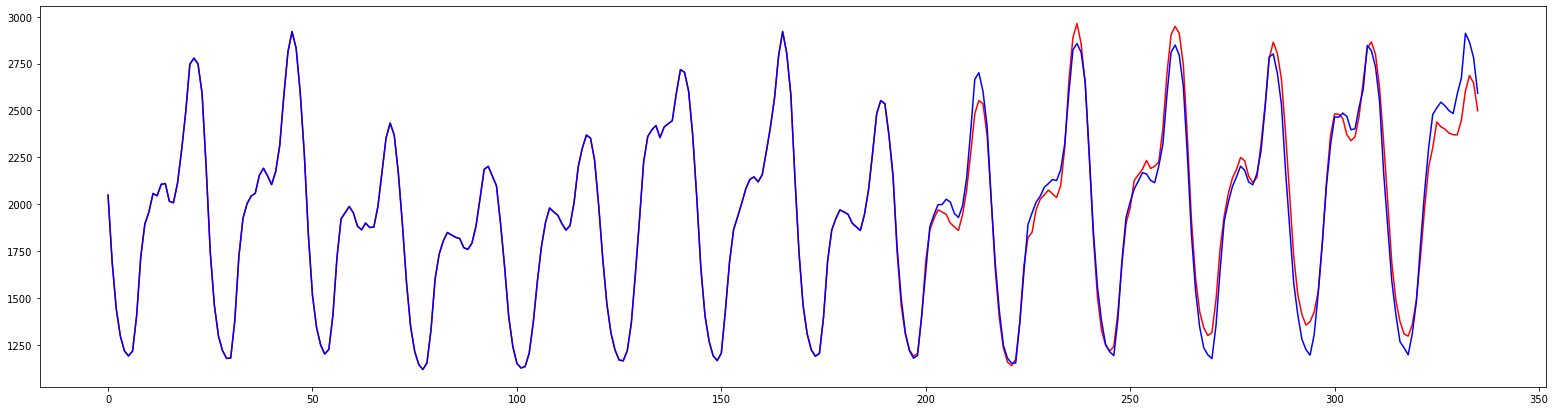

now : 51, sMAPE score : 3.0100901847902612


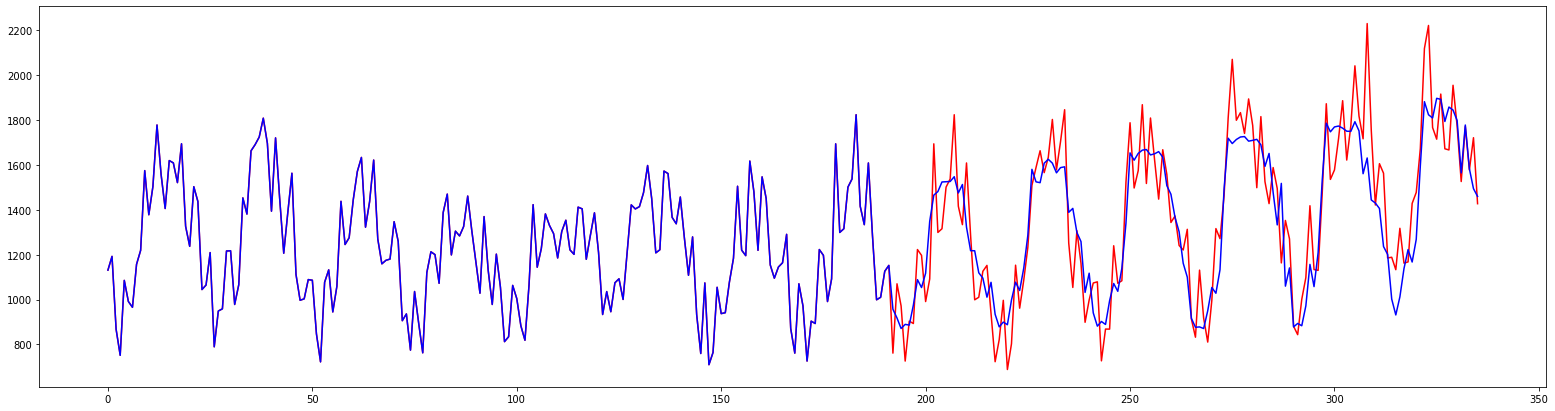

now : 59, sMAPE score : 8.644146911749806


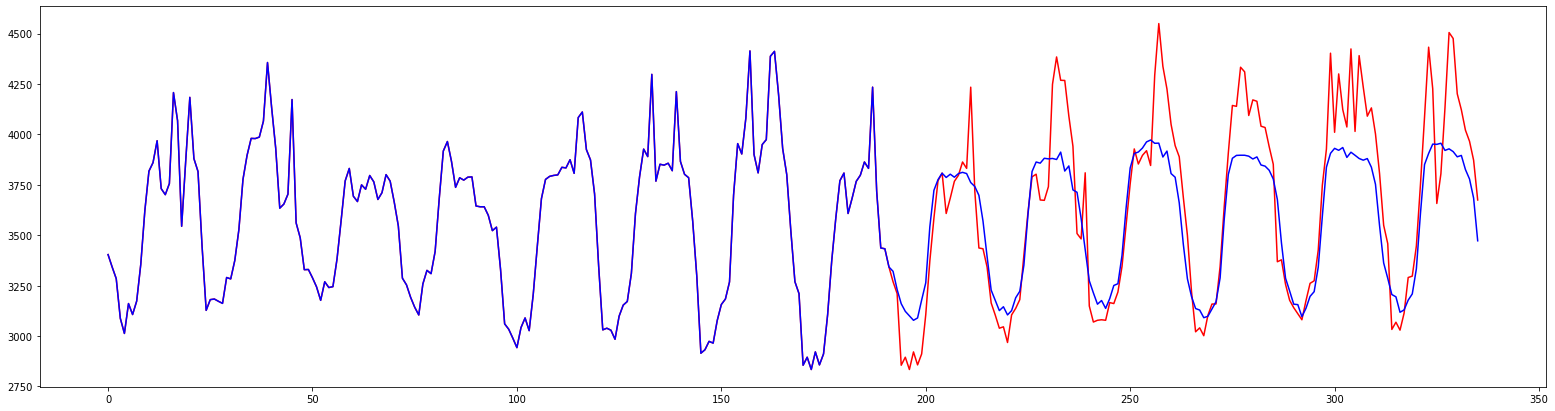

now : 60, sMAPE score : 3.9426439899417476
now step : 3, sMAPE score : 3.4221521518779827


In [7]:
all_smape = []
all_record = {}

for i in range(len(building_num)):
    temp = pd.read_csv(data_paths[i], index_col=0)
    now_dataframe = temp.loc[temp["num"] == building_num[i]].copy()
    now_dataframe = now_dataframe[start_point:start_point+input_length+duration]

    now_dataframe['num'] = now_dataframe['num'].apply(str)
    now_dataframe['Week'] = now_dataframe['Week'].apply(str)
    now_dataframe['24Hour'] = now_dataframe['24Hour'].apply(str)
    now_dataframe['holiday'] = now_dataframe['holiday'].apply(str)
    now_dataframe['Weekend'] = now_dataframe['Weekend'].apply(str)
    if not checking_tag[i].isdigit():
        now_dataframe['energy_group'] = now_dataframe['energy_group'].apply(str)

    now_best_tft = TemporalFusionTransformer.load_from_checkpoint(model_paths[i])

    original = now_dataframe.iloc[0:input_length+output_length]["kWH"].tolist()
    prediction = now_dataframe.iloc[0:input_length+output_length]["kWH"].tolist()

    total_cycle = (len(now_dataframe) - input_length - output_length) // output_length

    for k in range(total_cycle):
        now_start_point = k*output_length

        encoder_data = now_dataframe.iloc[now_start_point:now_start_point+input_length].copy()
        decoder_data = now_dataframe.iloc[now_start_point+input_length:now_start_point+input_length+output_length].copy()
        new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

        # get prediction, original data
        raw_predictions= now_best_tft.predict(new_prediction_data, mode="prediction").numpy().tolist()[0]
        originals = now_dataframe.iloc[now_start_point+input_length : now_start_point+input_length+output_length]["kWH"].tolist()

        prediction.extend(raw_predictions)
        original.extend(originals)

        # for next step, change dataframe's original value to predicted value
        for p in range(output_length):
            now_dataframe.iloc[now_start_point+input_length+p, now_dataframe.columns.get_loc("kWH")] = raw_predictions[p]
    
    if show_graph:            
        plt.rcParams["figure.figsize"] = (27,7)
        fig = plt.figure()
        graph = fig.add_subplot(1, 1, 1)
        graph.plot(original, color='red')
        graph.plot(prediction, color='blue')
        plt.show()

    smape_loss = smape(np.array(prediction[168:]), np.array(original[168:]))
    all_smape.append(smape_loss)
    all_record[f"{building_num[i]}"] = smape_loss
    print(f"now : {building_num[i]}, sMAPE score : {smape_loss}")

print(f"now step : {random_choice}, sMAPE score : {np.mean(np.array(all_smape))}")

In [8]:
print(f"now step : {random_choice}, sMAPE score : {np.mean(np.array(all_smape))}")

all_record_sorted = sorted(all_record.items(), key = lambda x:x[1], reverse=True)

for item in all_record_sorted:
    print(f"now : {item[0]}, sMAPE score : {item[1]}")

now step : 3, sMAPE score : 3.4221521518779827
now : 27, sMAPE score : 9.267527846982587
now : 5, sMAPE score : 8.995838200667883
now : 59, sMAPE score : 8.644146911749806
now : 18, sMAPE score : 7.614328736750307
now : 41, sMAPE score : 6.357375866858861
now : 11, sMAPE score : 6.287775234381384
now : 4, sMAPE score : 6.099886792403082
now : 15, sMAPE score : 6.025498774267037
now : 56, sMAPE score : 5.855832352458252
now : 42, sMAPE score : 5.804026325617797
now : 10, sMAPE score : 5.6059424866126175
now : 29, sMAPE score : 5.534558809507768
now : 23, sMAPE score : 4.929775236705732
now : 36, sMAPE score : 4.651837246207815
now : 48, sMAPE score : 4.568552644857766
now : 35, sMAPE score : 4.431417972204501
now : 40, sMAPE score : 4.388191569440005
now : 30, sMAPE score : 4.132385130217848
now : 60, sMAPE score : 3.9426439899417476
now : 24, sMAPE score : 3.9323263414940657
now : 7, sMAPE score : 3.7807500436430637
now : 43, sMAPE score : 3.587812802929427
now : 46, sMAPE score : 3.49